Autori: Bressanin Damiano, Cuciniello Claudio e Paulon Luca

Importazione delle librerie necessarie:

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

In [2]:
#SEED=432101234
#SEED = 999
#SEED = 123579
SEED = 42
#random.seed(42)
#random.seed(666)
#random.seed(123)
#random.seed(321)
#random.seed(4321)
random.seed(SEED)

Classe che rappresenta l'oggetto di tipo Nodo usato come struttura dati per memorizzare ed incapsulare le informazioni necessarie per l'esecuzione degli algoritmi:


* self.id: identidicatore numerico dell'attrazione
* self.nome: nome dell'attrazione
* self.gradimento: valore numerico che indica il gradimento ottenuto dalla prima visita dell'attrazione
* self.lista_tw: insieme delle Time Windows in cui è possibile andare a visitare l'attrazione
* self.t_arrivo: istante di arrivo nell'attrazione
* self.t_attesa: tempo di attesa dovuto all'arrivo anticipato presso l'attrazione
* self.t_visita: istante di visita dell'attrazione che comprende la somma dei tempi di arrivo e di attesa
* self.tw: Time Window usata per la visita dell'attrazione
* self.visitato: memorizza se l'attrazione è stata visitata oppure no
* self.dist_hotel: distanza tra l'attrazione e l'albergo



In [3]:
class Nodo:

    def __init__(self, id, nome,gradimento, lista_tw, t_arrivo,t_attesa,t_visita,tw,visitato,dist_hotel):
        self.id=id
        self.nome=nome
        self.gradimento=gradimento
        self.lista_tw=lista_tw
        self.t_arrivo=t_arrivo
        self.t_attesa=t_attesa
        self.t_visita=t_visita
        self.tw=tw
        self.visitato=False
        self.dist_hotel=dist_hotel

    def getGradimento(self):
        return self.gradimento

    def getApertura(self):
        return self.lista_tw[0][0]

    def getChiusura(self):
        return self.lista_tw[len(self.lista_tw)-1][1]

    def getDistanzaHotel(self):
        return self.dist_hotel

    def getRapportoGrdTw(self):
        ampiezze=[]
        for a in self.lista_tw:
            ampiezze.append(a[1]-a[0])
            piu_breve=sorted(ampiezze)[0]
        return self.gradimento/piu_breve


Funzioni di utilità:
* calcolo_attesa: dato l'istante di arrivo sull'attrazione e la prima Time Window utile restituisce valore 0 se si ricade dentro la Time Window, altrimenti restituisce il tempo che è necessario aspettare per poter visitare l'attrazione;
* get_nearest_TW: data l'attrazione e dato l'istante di arrivo su di essa, restituisce la prima Time Window disponibile, se presente, altrimenti None;
* ore_to_minuti: converte l'orario indicato in minuti;
* minuti_to_ore: converte i minuti in una tupla nel formato (ore, minuti);
*generate_random_distance_matrix: creazione matrice delle distanze con dentro numeri casuali
* plot_gradimenti_greedy: crea i grafici Greedy vs Gradimento
* if_ammissible_get_node: data la soluzione corrente e il prossimo nodo se è ammissibile viene ritornato il valore True ed il nodo successivo con i campi aggiornati
* petali_diversi: verifica se due petali sono diversi ovvero lunghezza diversa e attrazioni disposte in ordine diverso
* calcola_gradimento_petalo: itera su tutti i nodi del patalo sommando i gradimenti

In [4]:
def calcolo_attesa(tempo_controllo, start_tw):
  if start_tw-tempo_controllo>0:
    return start_tw-tempo_controllo
  else:
    return 0


def get_nearest_TW(tempo_controllo, nodo):
    lista_TW = nodo.lista_tw
    for i in range(len(lista_TW)):
        if (lista_TW[i][0] <= tempo_controllo <= lista_TW[i][1]):
            return lista_TW[i]
        else:
            if (lista_TW[i][0] > tempo_controllo):
                return lista_TW[i]
    return None


def ore_to_minuti(ore, minuti):
    ore = ore*60
    return ore + minuti


def minuti_to_ore(minuti):
    ore = 0
    while(minuti >= 60):
        minuti -= 60
        ore += 1
    return (ore,minuti)


def generate_random_distance_matrix(dimensione, min, max):
    # dimensione desiderata della matrice
    matrice = [[0] * dimensione for _ in range(dimensione)]
    # Riempimento della matrice con valori positivi
    for i in range(dimensione):
        for j in range(i+1, dimensione):
            # genero un valore random
            #valore = random.randint(15,60) #con il massimo a 200 ad ogni run cambiava di molto l'euristica migliore
            valore = random.randint(min,max)
            matrice[i][j] = valore
            matrice[j][i] = valore

    # Stampa della matrice
    for riga in matrice:
        print(riga)

    return matrice

def plot_gradimenti_greedy(all_solutions,all_gradimenti):

    x=np.arange(len(all_solutions))+1
    y=all_gradimenti
    names=[]
    for i in range(len(all_solutions)):
        if i==8:
            names.append('C&W')
        elif i==9:
            names.append('ad hoc')
        else:
            names.append('Best '+str(i+1))
    print(names)

    fig, axis=plt.subplots(1,2,figsize=(15,8))
    plt.figure(figsize=(9, 3))
    fig.suptitle('Soluzioni')

    #grafico 1
    axis[0].plot(x,y,'rs')
    axis[0].grid()
    axis[0].set_title('Rette spezzate')
    maxx=max(all_gradimenti)+5
    axis[0].set_ylim([0,maxx])
    axis[0].set_xlabel('Best')
    axis[0].set_ylabel('Gradimenti')

    #grafico 2
    axis[1].bar(names,y,color=['green'])
    axis[1].set_title('Istogramma')
    ylim=5+max(all_gradimenti)
    axis[1].set_ylim([0,ylim])
    axis[1].set_xlabel('Best')
    axis[1].set_ylabel('Gradimenti')

    plt.show()

def azzera_visite(attrazioni): #non serve
    for i in range(len(attrazioni)):
        attrazioni[i].visitato=False


def if_ammissible_get_node(soluzione_attuale, next_node):
    current_node = soluzione_attuale[-1]
    tempo_attuale = current_node.t_visita

    dist_current_to_next = D[current_node.id][next_node.id]
    dist_next_to_hotel = D[next_node.id][0]
    tempo_arrivo_next=tempo_attuale+dist_current_to_next

    tmp_tw = get_nearest_TW(tempo_attuale, next_node)

    if tmp_tw != None:

        attesa_next = calcolo_attesa(tempo_attuale, tmp_tw[0])
        t_visita_next = tempo_arrivo_next + attesa_next
        if  t_visita_next + dist_next_to_hotel <= FINE:
            next_node.t_arrivo=dist_current_to_next
            next_node.t_attesa=attesa_next
            next_node.t_visita=t_visita_next
            next_node.tw=tmp_tw
            next_node.visitato=True
            return (True, next_node)

    return (False,None)


#Due petali sono diversi se:
#1) hanno un numero diverso di nodi
#2) hanno la stessa lunghezza ma nodi diversi
def petali_diversi(Lp,Lpp):

    if len(Lp)!= len(Lpp):
        return True

    for i in range(len(Lp)):
        if Lp[i].id!=Lpp[i].id:
            return True

    return False

def calcola_gradimento_petalo(L):
    gradimento =0
    for l in L:
        gradimento+=l.gradimento
    return gradimento

def calcola_gradimento_soluzione(L):
    gradimento =0
    for l in L:
        gradimento+=l.gradimento
    return gradimento

# Creo una funzione per verificare l'ammissibilità:
# ho una soluzione attuale ammissibile e verifico se aggiungendo una nuova attrazione allora la nuova soluzione risulta ancora ammissibile
# se la nuova soluzione risulta ammissibile allora la funzione restituisce True, altrimenti False
# la creo perché potrebbe essere comoda per implementare gli altri algoritmi (es: Clarke & Wright) e per la pulizia

def isAmmissibile(soluzione_attuale, next_node):

    # il nodo corrente è l'ultimo aggiunto alla soluzione (tramite append, quindi)
    current_node = soluzione_attuale[-1]
    tempo_attuale = current_node.t_visita

    # calcolo le distanze ricordando che l'albergo l'abbiamo definito con id=0
    dist_current_to_next = D[current_node.id][next_node.id]
    dist_next_to_hotel = D[next_node.id][0]
    tempo_arrivo_next = tempo_attuale + dist_current_to_next

    # cerco la prima TW disponibile nel momento di arrivo alla prossima attrazione
    tmp_tw = get_nearest_TW(tempo_arrivo_next, next_node)

    # se esiste una TW che mi permette di visitare il nodo
    if tmp_tw != None:

        # allora ha senso controllare i tempi
        attesa_next = calcolo_attesa(tempo_arrivo_next, tmp_tw[0])
        t_visita_next = tempo_arrivo_next + attesa_next

        if t_visita_next + dist_next_to_hotel <= FINE:
            return True

    # se la computazione arriva fino a qui significa che non esiste la TW
    # oppure non è stato fatto il return precedente.

    # quindi di sicuro l'aggiunta del nodo rende la nuova soluzione non ammissibile
    return False

def pulizia(soluzione_attuale, lista_attrazioni):
    lista_pulita=[]
    for i in range(len(lista_attrazioni)):
        if (lista_attrazioni[i].visitato==False) and (isAmmissibile(soluzione_attuale, lista_attrazioni[i])):
            lista_pulita.append(lista_attrazioni[i])
    return lista_pulita

def pulizia_solo_ammissibilita(soluzione_attuale, lista_attrazioni):
    lista_pulita=[]
    for i in range(len(lista_attrazioni)):
        #######
        # aggiungo l'if per non pulire l'hotel altrimenti ho problemi di lista vuota in alcuni punti
        #######
        if lista_attrazioni[i].id==0:
            lista_pulita.append(lista_attrazioni[i])
        else:
            if isAmmissibile(soluzione_attuale, lista_attrazioni[i]):
                lista_pulita.append(lista_attrazioni[i])
    return lista_pulita

def if_node_ammissible_get_list(soluzione_attuale, next_node):
    if isAmmissibile(soluzione_attuale, next_node) == True:
        current_node = soluzione_attuale[-1]
        dist_current_to_next = D[current_node.id][next_node.id]
        tempo_attuale = current_node.t_visita
        tempo_arrivo_next = tempo_attuale + dist_current_to_next

        tmp_tw = get_nearest_TW(tempo_arrivo_next, next_node)
        attesa_next = calcolo_attesa(tempo_arrivo_next, tmp_tw[0])
        t_visita_next = tempo_arrivo_next + attesa_next

        # completo le informazioni mancanti del nodo
        next_node.t_arrivo = tempo_arrivo_next
        next_node.t_attesa = attesa_next
        next_node.t_visita = t_visita_next
        next_node.tw = tmp_tw
        next_node.visitato=True

        #aggiungo il nodo aggiornato alla lista
        soluzione_attuale.append(next_node)

    # metto il return fuori dall'if apposta, in modo che se il nodo era ammissibile allora è stato aggiunto, altrimenti no e restituisco la lista invariata
    return soluzione_attuale

def if_list_ammissible_merge_lists(soluzione_attuale, altra_lista):
    for i in range(len(altra_lista)):
        # non so se la sintassi sia corretta ma l'idea è questa: scorrere tutti gli elementi della lista 2 e provarli ad attaccarli alla lista 1
        soluzione_attuale = if_node_ammissible_get_list(soluzione_attuale, altra_lista[i])
    return soluzione_attuale

In [5]:
# stampa a video di alcune caratteristiche dei nodi di una lista
def myprint(testo,lista):
    print("\n", testo)
    for i in range(len(lista)):
        print(lista[i].nome, lista[i].id, lista[i].t_attesa, lista[i].gradimento, lista[i].t_visita)

In [6]:
#random.seed(123)

# generatore di Time Window casuali.
# dato il numero di attrazioni, genera la lista di tuple delle TW per ogni attrazione


# funzione ausiliaria
def double_split_and_extract(tupla_uno, tupla_due):
    # prendo in ingresso due tuple, le divido in 3 parti uguali (arrotondo per difetto), considero solo ed esclusivamente la parte centrale che uso per estrarre un valore di inizio e fine della TW

    # prendo la dimensione della tupla e la taglio in 3 ottenendo la dimensione di ogni sottointervallo
    # in poche parole: lo uso come offset
    passo_uno = math.floor((tupla_uno[1]-tupla_uno[0])/3)

    # per sotto_intervallo intendo proprio l'intervallo centrale: ne prendo l'inizio e la fine
    inizio_sotto_intervallo_uno = tupla_uno[0] + passo_uno
    fine_sotto_intervallo_uno = inizio_sotto_intervallo_uno + passo_uno

    # estrazione di un numero randomico compreso all'interno dell'intervallo centrale della prima tupla: ho trovato l'inizio della TW
    inizio_random_TW = random.randint(inizio_sotto_intervallo_uno, fine_sotto_intervallo_uno)

    ### RIPETO PER LA SECONDA TUPLA ###

    # prendo la dimensione della tupla e la taglio in 3 ottenendo la dimensione di ogni sottointervallo
    # in poche parole: lo uso come offset
    passo_due = math.floor((tupla_due[1] - tupla_due[0])/3)

    # per sotto_intervallo intendo proprio l'intervallo centrale: ne prendo l'inizio e la fine
    inizio_sotto_intervallo_due = tupla_due[0]+passo_due
    fine_sotto_intervallo_due = inizio_sotto_intervallo_due + passo_due

    # estrazione di un numero randomico compreso all'interno dell'intervallo centrale della seconda tupla: ho trovato la fine della TW
    fine_random_TW = random.randint(inizio_sotto_intervallo_due, fine_sotto_intervallo_due)

    # costruisco la tupla della TW e la restituisco
    random_TW = (inizio_random_TW,fine_random_TW)

    return random_TW


# funzione che genera la lista di tuple delle TW per una singola attrazione
def random_TW_Generator(N_TW):
    # test sugli input: devi darle un numero da 1 a 65
    if N_TW <=0 or N_TW > 65:
        print("Stai usando male la random_TW_Generator: passa un parametro sensato, non", N_TW)
        return None

    fine_giornata = ore_to_minuti(23,59)

    double_N_TW = 2* N_TW
    intervallo = math.floor(fine_giornata/double_N_TW)
    cont = 0
    lista_intervalli=[]

    while(cont+intervallo < fine_giornata):
        tmp_start = cont
        tmp_end = cont + intervallo
        lista_intervalli.append((tmp_start,tmp_end))
        cont=tmp_end


    lista_TW_finale=[]

    #chiamo la reverse per avere le TW ordinate in senso decrescente perché voglio usare la pop()
    lista_intervalli.reverse()

    while(lista_intervalli):
        # estraggo le coppie di tuple per generare la TW finale
        tmp_primo_intervallo = lista_intervalli.pop()
        tmp_secondo_intervallo = lista_intervalli.pop()
        TW_finale = double_split_and_extract(tmp_primo_intervallo,tmp_secondo_intervallo)
        lista_TW_finale.append(TW_finale)

    return lista_TW_finale

N_TW_MIN = 1
N_TW_MAX = 4
# funzione che genera la lista di liste di tuple delle TW per un numero generico di attrazioni
def genera_TW_attrazioni(N_attrazioni):
    lista = []
    for i in range(N_attrazioni):
        # io l'ho scelto a caso ma si può passare come parametro oppure si può fissare ad un numero scelto
        #N_TW = random.randint(1,4)
        N_TW = random.randint(N_TW_MIN,N_TW_MAX)
        #lista di tuple di TW
        TW_attrazione = random_TW_Generator(N_TW)
        lista.append(TW_attrazione)


    return lista

In [7]:
# funzione che clona la lista in ingresso fornendo una lista nuova identica in uscita
def clona_lista(lista):
    nuova = []
    for a in lista:
        id=a.id
        nome=a.nome
        gradimento=a.gradimento
        lista_tw=a.lista_tw
        visitato=a.visitato
        d_hotel=a.dist_hotel
        t_arrivo=a.t_arrivo
        t_attesa=a.t_attesa
        t_visita=a.t_visita
        tw=a.tw
        nuova.append(Nodo(id,nome,gradimento,lista_tw,t_arrivo,t_attesa,t_visita,tw,visitato,d_hotel))
    return nuova

Inizializzazione di: Liste, Matrici e Dizionari necessarie

* dizionari:
    * attrazioni: coppie id:nome di ogni attrazione
    * gradimenti: coppie id:gradimento di ogni attrazione
    * TW: coppie id:lista di tuple di Time Window di ogni attrazione

* matrici:
    * D: matrice delle distanze tra tutte le coppie di attrazioni, compreso l'hotel

* variabili:
    * H: durata della visita;
    * START: istante di inizio del tour;
    * FINE: istante di fine del tour;
    * gradimento_tot: somma dei gradimenti delle attrazioni visitate;
    * t: tempo globale ed è sempre riferito all'istante di visita dell'ultima attrazione visitata. All'inizio vale START;

* liste:
    * soluzione: lista delle attrazioni che si visitano durante il tour;
    * chiusi: lista delle attrazioni visitate;
    * non_visitabili: lista delle attrazioni che non hanno una Time Window che consente di visitarle nel tempo a disposizione;
    * L: lista di tutte le attrazioni generata iterando nell'omonimo dizionario
    * all_solutions: concatena tutte le soluzioni trovate delle greedy costruttive
    * all_gradimenti: memorizza i gradimenti di ogni best



In [8]:
#attrazioni={1:"Attr1", 2:"Attr2", 3:"Attr3", 4:"Attr4",5:"Attr5",6:"Attr6",7:"Attr7"}
#gradimenti={1:10,2:5,3:7,4:1,5:2,6:3,7:4}

#TW={1:[(480,720),(840,1080)],
#    2:[(540,600),(858,1140)],
#    3:[(498,618),(780,900)],
#    4:[(600,738),(900,1020)],
#    5:[(600,678),(900,1158)],
#    6:[(558,798)],
#    7:[(1020,1200)]
#    }

###########################
attrazioni = {}
gradimenti = {}
numero_di_attrazioni = 10
for i in range(numero_di_attrazioni):
    attrazioni[i+1] = "Attr"+str(i+1)
    gradimenti[i+1] = random.randint(1,10)


###########################

###########################
random_TW_dictionary = {}
lista_di_tutte_le_TW_di_tutte_le_attrazioni = genera_TW_attrazioni(len(attrazioni.items()))
for i in range(len(lista_di_tutte_le_TW_di_tutte_le_attrazioni)):
    random_TW_dictionary.update({(i+1):lista_di_tutte_le_TW_di_tutte_le_attrazioni[i]})
TW = random_TW_dictionary

print("\nStampa delle TW")
for valore in random_TW_dictionary.values():
    print(valore)
print("\n")
###########################


#D=[[0,20,15,34,5600,12077,10,100],
#   [20,0,22,45,6000,1177,340,9],
#   [15,22,0,23,9000,7177,2,10],
#   [34,45,23,0,700,4077,13,82],
#   [5600,6000,9000,700,0,50077,22200,1300],
#   [12077,1177,7177,4077,50077, 0,1677,2777],
#   [10,340,2,13,22200,1677,0,1],
#   [100,9,10,82,1300,2777,1,0],
#   ]


#D=[[0,20,15,34,56,120,10,100],
#   [20,0,22,45,60,11,340,9],
#   [15,22,0,23,90,71,2,10],
#   [34,45,23,0,7,40,13,82],
#   [56,60,90,7,0,5,222,13],
#   [120,11,71,40,5, 0,16,27],
#   [10,340,2,13,222,16,0,1],
#   [100,9,10,82,13,27,1,0],
#   ]



###########################
# +1 per l'hotel
D_MIN = 5
D_MAX = 30
D = generate_random_distance_matrix(1+len(attrazioni.items()), D_MIN, D_MAX)
###########################

#H = 200
H=300
START=480
t=START #istante di visita dell'ultimo nodo
FINE=START+H
gradimento_tot=0

all_solutions=[]
all_gradimenti=[]
soluzione=[Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0)]
chiusi=[]
non_visitabili=[]
tempi_esecuzione=[]

#Creazione della lista di attrazioni di tipo nodo
L=[]
for key,value in attrazioni.items():
    L.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))




Stampa delle TW
[(61, 239), (422, 609), (789, 986), (1171, 1313)]
[(210, 561), (926, 1265)]
[(73, 266), (454, 613), (826, 1009), (1133, 1360)]
[(208, 532), (880, 1231)]
[(146, 575), (880, 1209)]
[(336, 982)]
[(123, 395), (590, 801), (1093, 1342)]
[(475, 1054)]
[(380, 1033)]
[(152, 342), (565, 801), (1064, 1311)]


[0, 7, 12, 8, 17, 13, 19, 25, 16, 10, 16]
[7, 0, 16, 11, 26, 13, 27, 26, 25, 7, 24]
[12, 16, 0, 25, 10, 22, 28, 12, 10, 19, 17]
[8, 11, 25, 0, 13, 25, 27, 22, 12, 26, 15]
[17, 26, 10, 13, 0, 29, 29, 6, 12, 6, 30]
[13, 13, 22, 25, 29, 0, 15, 17, 13, 7, 11]
[19, 27, 28, 27, 29, 15, 0, 23, 27, 15, 11]
[25, 26, 12, 22, 6, 17, 23, 0, 25, 20, 17]
[16, 25, 10, 12, 12, 13, 27, 25, 0, 25, 19]
[10, 7, 19, 26, 6, 7, 15, 20, 25, 0, 9]
[16, 24, 17, 15, 30, 11, 11, 17, 19, 9, 0]


Best "locali":
* Selezione delle attrazioni in ordine di distanza + attesa dall’hotel in senso crescente (prima quelle più vicine all'hotel);
* Si ordinano le attrazioni in base al loro rapporto (gratificazione/(durata spostamento+attesa)), si prendono le prime N migliori e non visitate e poi si sceglie a caso in quale tra le prime N attrazioni andare;


In [9]:
def best_greedy_5(attrazioni, current_node):

    for i in range(len(attrazioni)):
        tmp_current_time = current_node.t_visita
        tmp_dist_hotel = attrazioni[i].dist_hotel
        tmp_tw = get_nearest_TW(tmp_dist_hotel + tmp_current_time, attrazioni[i])
        if tmp_tw != None:
            tmp_attesa = calcolo_attesa(tmp_dist_hotel + tmp_current_time, tmp_tw[0])
            attrazioni[i].t_visita = tmp_dist_hotel + tmp_attesa + tmp_current_time

    sorted_attrazioni=sorted(attrazioni,key=lambda x: x.t_visita,reverse=False)

    return sorted_attrazioni

nodo_per_greedy_5 = Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0)
attrazione_per_greedy = best_greedy_5(L,nodo_per_greedy_5)[0]

In [10]:
# Va ricalcolata ogni volta
# Sono nel Nodo i (fissato) e devo andare al Nodo j (devo deciderlo).
# L'ora attuale è t_attuale = t_visita del Nodo i.
# Si devono ordinare le attrazioni in ordine di gradimento/(distanza + attesa) in senso decrescente;
# Poi prendo le prime N attrazioni migliori (se N è più grande della lista allora N=len(lista)) e ne scelgo una a caso

def best_greedy_6(attrazioni, current_node, N):
    tmp_list=[]
    sorted_attrazioni = []
    for i in range(len(attrazioni)):
        if (attrazioni[i].id != current_node.id) and (attrazioni[i].visitato!=True):
            tmp_dist_current_to_next = D[attrazioni[i].id][current_node.id]
            tmp_t_arrivo_next = current_node.t_visita + tmp_dist_current_to_next
            tmp_tw = get_nearest_TW(tmp_t_arrivo_next, attrazioni[i])
            if tmp_tw != None:
                tmp_attesa = calcolo_attesa(tmp_dist_current_to_next, tmp_tw[0])
                attrazioni[i].t_visita = tmp_t_arrivo_next + tmp_attesa
                tmp_list.append(attrazioni[i])
    sorted_attrazioni=sorted(tmp_list,key=lambda x: (x.getGradimento()/(x.t_visita)),reverse=True)
    if len(sorted_attrazioni)==0:
        #Caso speciale in cui non ho attrazioni disponibili perché ho finito le TW. Restituisco None")
        return None
    percentuale_random = 0.2
    print("len(sorted_attrazioni)=",len(sorted_attrazioni))
    print("N passato come parametro=",N)
    N = max(N, math.floor(len(sorted_attrazioni)*percentuale_random))
    print("N dopo il max(N, math.floor(len(sorted_attrazioni)*percentuale_random)) = ", N)
    scelta=1
    if (N<=1):
        N=1
        scelta=1
    else:
        if (N > len(sorted_attrazioni)):
            N = len(sorted_attrazioni)
            print("N prima di chiamare la funzione di scelta random =", N)
            if (N == 0):
                N = 1
            scelta = random.randint(1,N)
    elem=sorted_attrazioni.pop(scelta-1)
    sorted_attrazioni.insert(0,elem)
    return sorted_attrazioni

In [11]:
#Best 7
#Best: (dopo aver escluso quelle non visitabili)
#1	C = cerca l'attrazione che chiude per prima.
#2	A = cerca lista attrazioni che aprono prima dell'apertura di C.
#3	C = cerca l'attrazione che chiude prima in (A) => ritorno al passo 1.
#Ripeti fino ad arrivare al caso base e poi procedi con la visita nell'ordine ottenuto.

def best_greedy_7(L_attr):
    L_attr=pulizia([Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0)],L_attr)

    L_attr_tuple=[]
    L_sol=[]
    i=0

    while len(L_attr)!=0:

        #chi chiude prima
        if i%2==0:

            L_attr_tuple=[]

            for a in L_attr:
                L_attr_tuple.append((a,get_nearest_TW(START,a)[1]))
            L_attr_tuple.sort(key=lambda t: t[1])
            estratto=L_attr_tuple.pop(0)[0] # prendo l'attrazione che chiude prima

            if len(L_sol)==0:
                L_sol.append(estratto)

            for j in range(len(L_sol)):
                start_tw_estratto=get_nearest_TW(START,estratto)[0]
                start_tw_j=get_nearest_TW(START,L_sol[j])[0]
                if calcolo_attesa(START,start_tw_estratto)<calcolo_attesa(START,start_tw_j): #se l'attesa per andare da Start a
                    L_sol.insert(j,estratto)  #inserisco il nodo estratto se ha attesa minore dei nodi in soluzione
                    break

            for k in range(len(L_attr)):
                if L_attr[k].id==estratto.id:
                    L_attr.pop(k) # togli dalle attrazioni il nodo estratto
                    break

        else:#chi apre prima
            for a in L_attr:
                L_attr_tuple.append((a,get_nearest_TW(START,a)[0]))
            L_attr_tuple.sort(key=lambda t: t[1])
            estratto=L_attr_tuple.pop(0)[0]  # prendo l'attrazione che apre prima

            if len(L_sol)==0:
                L_sol.append(estratto)

            for j in range(len(L_sol)):
                start_tw_estratto=get_nearest_TW(START,estratto)[0]
                start_tw_j=get_nearest_TW(START,L_sol[j])[0]
                if calcolo_attesa(START,start_tw_estratto)<calcolo_attesa(START,start_tw_j):
                    L_sol.insert(j,estratto)
                    break

            for k in range(len(L_attr)):
                if L_attr[k].id==estratto.id:
                    L_attr.pop(k)
                    break

        i+=1

    return L_sol


In [12]:
all_solutions=[]
all_gradimenti = []
for i in range(8):
    inizio=time.time()

    if i==0:
        best=lambda x: x.getGradimento()
        reverse=True
        isGlobale=True
    elif i==1:
        best=lambda x: x.getApertura()
        reverse=False
        isGlobale=True
    elif i==2:
        best=lambda x: x.getChiusura()
        reverse=False
        isGlobale=True
    elif i==3:
        best=lambda x: x.getRapportoGrdTw()
        reverse=True
        isGlobale=True
    elif i==4:
        best=lambda x: x.getDistanzaHotel()
        reverse=False
        isGlobale=True
    elif i==5:
        best= best_greedy_5
        isGlobale=False
    elif i==6:
        best=best_greedy_6
        isGlobale=False
    elif i==7:
        best=best_greedy_7
        isGlobale=True

    gradimento_tot=0
    chiusi=[]
    non_visitabili=[]
    soluzione=[Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0)]
    t=START
    L=[]
    for key,value in attrazioni.items():
        L.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))

    L_sorted=[]
    if isGlobale:
        if i!=7:
            L_sorted=sorted(L,key=best,reverse=reverse)
        else:
            L_sorted=best(L)
    else:
        for key,value in attrazioni.items():
            L_sorted.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))

    while len(L_sorted)!=0 and t<=FINE:

        current=soluzione[len(soluzione)-1]

      #eliminazione delle attrazioni che non si possono visitare
        while L_sorted:

            a=L_sorted[0]

            lastTW=a.lista_tw[len(a.lista_tw)-1]
            if t + D[current.id][a.id] > lastTW[1] :
                L_sorted.remove(a)
                non_visitabili.append(a)
            if len(L_sorted)==0:
                break

            #estrazione
            if not isGlobale:
                if i==5:
                    L_sorted = best(L_sorted, current)
                elif i==6:
                    L_sorted=best(L_sorted,current,3)

            bestA=L_sorted.pop(0)
            chiusi.append(bestA)
            tw=get_nearest_TW(t+D[current.id][bestA.id],bestA)

            if tw!=None:
                t_arrivo=t+D[current.id][bestA.id]
                t_attesa=calcolo_attesa(t+D[current.id][bestA.id],tw[0])
                t_visita=t+D[current.id][bestA.id]+t_attesa

                bestA.t_arrivo=t_arrivo
                bestA.t_attesa=t_attesa
                bestA.t_visita=t_visita
                bestA.tw=tw
                bestA.visitato=True
                #verifica se aggiungendo il nodo alla soluzione si ha tempo di ritornare indietro
                if bestA.t_visita + bestA.dist_hotel <FINE:
                    soluzione.append(bestA)
                    gradimento_tot+=bestA.gradimento
                    t=bestA.t_visita


    tempo=(time.time()-inizio)*1000
    tempi_esecuzione.append(tempo)

    all_gradimenti.append(gradimento_tot)
    all_solutions.append(soluzione)
    print("Best "+str(i+1))
    print("Gradimento "+str(gradimento_tot))
    for x in soluzione:
        print(str(x.id)+ ' '+ str(x.nome)+ ' '+ str(x.gradimento)+ ' '+ str(x.tw) + ' '+ str(x.t_visita) + ' ' + str(x.t_attesa))

Best 1
Gradimento 31
0 Hotel 0 (0, 1440) 480 0
10 Attr10 10 (565, 801) 565 69
8 Attr8 9 (475, 1054) 581 0
3 Attr3 5 (454, 613) 589 0
6 Attr6 3 (336, 982) 608 0
7 Attr7 2 (590, 801) 633 0
9 Attr9 2 (380, 1033) 643 0
Best 2
Gradimento 33
0 Hotel 0 (0, 1440) 480 0
1 Attr1 2 (422, 609) 487 0
3 Attr3 5 (454, 613) 495 0
7 Attr7 2 (590, 801) 590 70
10 Attr10 10 (565, 801) 606 0
6 Attr6 3 (336, 982) 625 0
9 Attr9 2 (380, 1033) 635 0
8 Attr8 9 (475, 1054) 651 0
Best 3
Gradimento 38
0 Hotel 0 (0, 1440) 480 0
6 Attr6 3 (336, 982) 499 0
9 Attr9 2 (380, 1033) 509 0
8 Attr8 9 (475, 1054) 525 0
5 Attr5 4 (146, 575) 538 0
2 Attr2 1 (210, 561) 550 0
10 Attr10 10 (565, 801) 566 0
1 Attr1 2 (422, 609) 573 0
7 Attr7 2 (590, 801) 598 0
3 Attr3 5 (454, 613) 606 0
Best 4
Gradimento 33
0 Hotel 0 (0, 1440) 480 0
10 Attr10 10 (565, 801) 565 69
3 Attr3 5 (454, 613) 573 0
8 Attr8 9 (475, 1054) 589 0
1 Attr1 2 (422, 609) 596 0
7 Attr7 2 (590, 801) 621 0
6 Attr6 3 (336, 982) 640 0
9 Attr9 2 (380, 1033) 650 0
Best 5

Clarke & Wright
L'algoritmo si divide in due fasi:
* creazione singoli petali
* aggancio di petali in tutte le possibili combinazioni

In [13]:

def clarke_e_wright(L_attr):
    #lista con singoli petali
    #ogni singolo petalo è una lista con un solo nodo
    L_petali=[]
    L_non_petali=[]
    for a in Lista_attr:
        id=a.id
        nome=a.nome
        gradimento=gradimenti[id]
        lista_tw=TW[id]
        visitato=False
        d_hotel=D[0][id]
        t_arrivo=D[0][id]
        tw=get_nearest_TW(t_arrivo,a)
        #Se al dato tempo di arrivo esiste una tw si crea il singolo petalo altrimenti no
        if tw!=None:
            t_attesa=calcolo_attesa(t_arrivo,tw[0])
            t_visita=t_arrivo+t_attesa
            L_petali.append([Nodo(id,nome,gradimento,lista_tw,t_arrivo,t_attesa,t_visita,tw,visitato,d_hotel)])
        else:
            L_non_petali.append(a)


    print("Singoli petali")
    print(L_petali)
    for p in L_petali:
        print(str(p[0].id)+ " "+str(p[0].nome)+" Arrivo="+str(p[0].t_arrivo)+" Attesa="+str(p[0].t_attesa)+" Visita"+str(p[0].t_visita)+" "+str(p[0].tw))

    print("\n")
    for Lp in L_petali:
        for Lpp in L_petali:
            if len(Lp)!=0 and len(Lpp)!=0 and petali_diversi(Lp,Lpp):
                #se l'ultimo nodo del primo petalo viene visitato prima del primo nodo del secondo petalo
                #aggancio: [p][pp]
                if Lp[-1].t_visita < Lpp[0].t_visita:
                    for pp in Lpp:
                        #verifica se il primo nodo si pp può essere
                        #inserito in Lp
                        is_ammissible, new_pp=if_ammissible_get_node(Lp,pp)
                        if is_ammissible:
                            Lp.append(new_pp)
                            Lpp.remove(pp)
                        else:
                            L_non_petali.append(pp)
                    #L_petali.remove(Lpp)
                else:
                    #aggancio [pp][p]
                    for p in Lp:
                        #verifica se il primo nodo si p può essere
                        #inserito in Lpp
                        is_ammissible, new_p=if_ammissible_get_node(Lpp,p)
                        if is_ammissible:
                            Lpp.append(new_p)
                            Lp.remove(p)
                        else:
                            L_non_petali.append(p)
                    #L_petali.remove(Lp)

    best_petalo=[]
    best_gradimento_petalo=0

    for petalo in L_petali:
        gradimento_petalo=calcola_gradimento_petalo(petalo)

        if(gradimento_petalo>best_gradimento_petalo):
            best_gradimento_petalo=gradimento_petalo
            best_petalo=petalo

        print("Gradimento= "+str(gradimento_petalo))
        #for elem in petalo:
        #    print(str(elem.id)+" "+str(elem.nome))
        myprint("Petalo =", petalo)

    print('\nBest petalo')
    for elem in best_petalo:
        print(str(elem.id)+" "+str(elem.nome))

    best_petalo=aggiungi_hotel(best_petalo)
    return best_petalo

In [14]:
def aggiungi_hotel(soluzione_senza_hotel):
    soluzione = clona_lista(soluzione_senza_hotel)

    if soluzione[0].id != 0:
        soluzione.insert(0,Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0))

    if soluzione[-1].id != 0:

        hotel_con_tempi = Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0)
        hotel_con_tempi.t_arrivo = soluzione[-1].t_visita + D[soluzione[-1].id][0]
        hotel_con_tempi.t_visita = soluzione[-1].t_visita + D[soluzione[-1].id][0]

        soluzione.append(hotel_con_tempi)
    return soluzione

In [15]:
#lista di nodi di tipo attrazione
Lista_attr=[]
for key,value in attrazioni.items():
    Lista_attr.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))

inizio=time.time()

best_petalo=clarke_e_wright(Lista_attr)

tempo=(time.time()-inizio)*1000
tempi_esecuzione.append(tempo)
all_solutions.append(best_petalo)
all_gradimenti.append(calcola_gradimento_petalo(best_petalo))

Singoli petali
[[<__main__.Nodo object at 0x7f784a7ab9d0>], [<__main__.Nodo object at 0x7f784a7ab940>], [<__main__.Nodo object at 0x7f784a7a9ea0>], [<__main__.Nodo object at 0x7f784a7aac80>], [<__main__.Nodo object at 0x7f784a7ab8b0>], [<__main__.Nodo object at 0x7f784a7ab910>], [<__main__.Nodo object at 0x7f784a7ab820>], [<__main__.Nodo object at 0x7f784a7a89d0>], [<__main__.Nodo object at 0x7f784a7a8040>], [<__main__.Nodo object at 0x7f784a7aad40>]]
1 Attr1 Arrivo=7 Attesa=54 Visita61 (61, 239)
2 Attr2 Arrivo=12 Attesa=198 Visita210 (210, 561)
3 Attr3 Arrivo=8 Attesa=65 Visita73 (73, 266)
4 Attr4 Arrivo=17 Attesa=191 Visita208 (208, 532)
5 Attr5 Arrivo=13 Attesa=133 Visita146 (146, 575)
6 Attr6 Arrivo=19 Attesa=317 Visita336 (336, 982)
7 Attr7 Arrivo=25 Attesa=98 Visita123 (123, 395)
8 Attr8 Arrivo=16 Attesa=459 Visita475 (475, 1054)
9 Attr9 Arrivo=10 Attesa=370 Visita380 (380, 1033)
10 Attr10 Arrivo=16 Attesa=136 Visita152 (152, 342)


Gradimento= 0

 Petalo =
Gradimento= 0

 Petalo

In [16]:
#Eusristica ad HOC TSP
def attrazioni_non_visitabili(L, start, fine):
    visitabili = []
    tw_i = []
    for a in L:
        tw_a = a.lista_tw
        for i in tw_a:
            if (visitabili.count(a) == 0):
                if(start <=i[0] <= fine or start <=i[1] <= fine):
                    visitabili.append(a)

    return visitabili

def find_nearest_node(current, L_visitabili):
    min_d=100000000
    nearest_attr=None
    for a in L_visitabili:
        if D[current.id][a.id]<min_d:
            min_d=D[current.id][a.id]
            nearest_attr=a

    return nearest_attr

def find_node_lowest_gradimento(circuito):

    node=None
    min_g=1000

    for n in circuito:
        if n.gradimento<min_g:
            node=n
            min_g=n.gradimento
    return node

def durata_circuito(circuito):

    durata=0
    for i in range(len(circuito)-1):
        durata+= D[circuito[i].id][circuito[i+1].id]
        print('Sono nel nodo '+str(circuito[i].nome)+ ' per andare al nodo '+str(circuito[i+1].nome)+ ' impego '+str( D[circuito[i].id][circuito[i+1].id]))
    durata+=D[circuito[-1].id][circuito[0].id]

    return durata

def euristica_ad_hoc_TSP(L_attrazioni):
    gradimento_TSP=0
    L_selezionati=attrazioni_non_visitabili(L,START,FINE)
    nearest=None
    #Nearest neighbout TSP
    circuito=[Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0)]
    #1)Creazione circuito grande
    while L_selezionati:
        #cercare attrazione più vicina alla soluzione corrente
        #senza verificare l'ammissibilità
        nearest=find_nearest_node(circuito[-1],L_selezionati)
        circuito.append(nearest)
        L_selezionati.remove(nearest)
    #2)Creazione circuito piccolo
    #nella funzione si considera il tempo per tornare all'hotel
    while durata_circuito(circuito)>H:
        node=find_node_lowest_gradimento(circuito[1:])
        circuito.remove(node)
    #3) Scelta delle attrazioni in ordine di gradimento decrescente (prima quelle con gradimento maggiore)
    best=lambda x: x.getGradimento()
    reverse = True
    isGlobale=True
    s=sorted(circuito[1:],key=best,reverse=reverse)
    s.insert(0,Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0))
    circuito=s
    #4) Verificare se la sequenza è ammissibile
    circuito_ammissibile=if_list_ammissible_merge_lists([circuito[0]],circuito[1:])

    return circuito_ammissibile


#Creazione della lista di attrazioni di tipo nodo
L=[]
for key,value in attrazioni.items():
    L.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))


inizio=time.time()
circuito=euristica_ad_hoc_TSP(L)
tempo=(time.time()-inizio)*1000

tempi_esecuzione.append(tempo)
all_solutions.append(circuito)
all_gradimenti.append(calcola_gradimento_soluzione(circuito))

print("calcola_gradimento_soluzione(circuito)",calcola_gradimento_soluzione(circuito))
for n in circuito:
    print(n.nome)

Sono nel nodo Hotel per andare al nodo Attr1 impego 7
Sono nel nodo Attr1 per andare al nodo Attr3 impego 11
Sono nel nodo Attr3 per andare al nodo Attr4 impego 13
Sono nel nodo Attr4 per andare al nodo Attr7 impego 6
Sono nel nodo Attr7 per andare al nodo Attr2 impego 12
Sono nel nodo Attr2 per andare al nodo Attr10 impego 17
Sono nel nodo Attr10 per andare al nodo Attr5 impego 11
calcola_gradimento_soluzione(circuito) 19
Hotel
Attr10
Attr3
Attr1
Attr7


['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


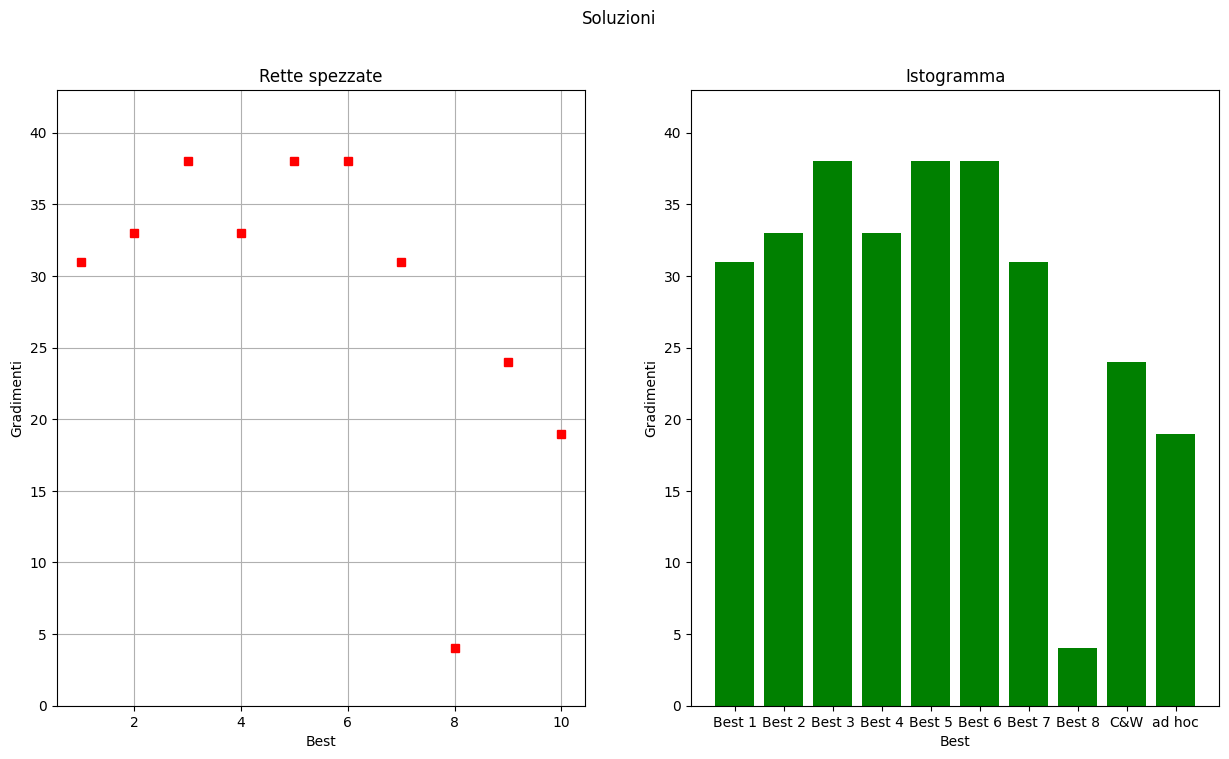

<Figure size 900x300 with 0 Axes>

In [17]:
#Stampa delle solzuioni con matplot lib
plot_gradimenti_greedy(all_solutions,all_gradimenti)

In [18]:
# funzione che verifica se un nodo (attrazione) non compare all'interno di una lista di attrazioni
def not_member(nodo, lista):
    for i in range(len(lista)):
        if nodo.nome == lista[i].nome:
            return False
    return True

In [19]:
# funzione che prende in ingresso una lista di liste e restituisce la lista i-esima senza hotel
def estrai_da_LL(lista_di_liste, indice_lista):
    tmp_list = []
    for j in range(len(lista_di_liste[indice_lista])):
        if lista_di_liste[indice_lista][j].id != 0:
            tmp_list.append(lista_di_liste[indice_lista][j])
    return tmp_list

In [20]:
# funzione che prende in ingresso una lista di nodi e restituisce una lista nuova che non contiene il nodo con l'id specificato come secondo parametro
def remove_nodo_by_id(lista_nodi, id):
    tmp_lista = []
    for i in range(len(lista_nodi)):
        if lista_nodi[i].id != id:
            tmp_lista.append(lista_nodi[i])
    return tmp_lista

In [21]:
def append_node_in_list(soluzione_attuale, next_node):
    current_node = soluzione_attuale[-1]
    tempo_attuale = current_node.t_visita

    dist_current_to_next = D[current_node.id][next_node.id]
    tempo_arrivo_next=tempo_attuale+dist_current_to_next

    tmp_tw = get_nearest_TW(tempo_attuale, next_node)

    if tmp_tw != None:

        attesa_next = calcolo_attesa(tempo_attuale, tmp_tw[0])
        t_visita_next = tempo_arrivo_next + attesa_next

        next_node.t_arrivo=dist_current_to_next
        next_node.t_attesa=attesa_next
        next_node.t_visita=t_visita_next
        next_node.tw=tmp_tw
        next_node.visitato=True

        soluzione_attuale.append(next_node)
        #return soluzione_attuale
    else:
        print("CASO SPECIALE: nella funzione append_node_in_list, sono nell'attrazione ", current_node.nome, " e sto provando ad andare in next_node=", next_node.nome, " ma non ho tw disponibili")
        print("current_node.t_visita=",current_node.t_visita)
        print("next_node.tw=", next_node.lista_tw)

    return soluzione_attuale

In [22]:
def insert_node_in_lists(first_list, next_node, second_list):
    if isAmmissibile_DR(first_list, next_node, second_list) == True:
        second_list.insert(0,next_node)
        for i in range(len(second_list)):
            first_list = clona_lista(append_node_in_list(first_list, second_list[i]))

        for i in range(len(first_list)):
            print("Sono il nodo=", first_list[i].nome)
            print("t_arrivo=", first_list[i].t_arrivo)
            print("t_visita=", first_list[i].t_visita)
            print("tw=", first_list[i].tw)

        return first_list
    else:
        return first_list + second_list


In [23]:
def isAmmissibile_DR(first_list, next_node, second_list):

    # il nodo corrente è l'ultimo aggiunto alla soluzione (tramite append, quindi)
    myprint("first_list", first_list)
    myprint("second_list",second_list)

    moncone_sx = first_list[-1]
    moncone_dx = second_list[0]
    tempo_attuale = moncone_sx.t_visita
    tempo_arrivo_old = moncone_dx.t_visita

    # calcolo le distanze
    dist_moncone_sx_to_next = D[moncone_sx.id][next_node.id]
    dist_next_to_moncone_dx = D[next_node.id][moncone_dx.id]
    tempo_arrivo_next = tempo_attuale + dist_moncone_sx_to_next
    #tempo_arrivo_new = tempo_arrivo_next + dist_next_to_moncone_dx

    # cerco la prima TW disponibile nel momento di arrivo alla prossima attrazione
    tmp_tw = get_nearest_TW(tempo_arrivo_next, next_node)

    # se esiste una TW che mi permette di visitare il nodo
    if tmp_tw != None:
        # allora ha senso controllare i tempi
        attesa_next = calcolo_attesa(tempo_arrivo_next, tmp_tw[0])
        t_visita_next = tempo_arrivo_next + attesa_next

        if t_visita_next + dist_next_to_moncone_dx <= tempo_arrivo_old and t_visita_next + dist_next_to_moncone_dx <= FINE:
            # esattamente in questa riga si potrebbe chiamare una funzione che aggiunge il nodo in coda alla lista soluzione
            # ho tutti i parametri che mi servono ma non mi piace come idea perché si andrebbe oltre lo scopo di questa funzione
            return True

    # se la computazione arriva fino a qui significa che non esiste la TW oppure non è stato fatto il return precedente.
    # quindi di sicuro l'aggiunta del nodo rende la nuova soluzione non ammissibile
    return False

In [24]:
def get_nodo_by_id(lista, id):
    for i in range(len(lista)):
        if lista[i].id == id:
            return lista[i]

In [25]:
# funzione che trova la distanza tra la chiusura della tw e il tempo di visita
def find_min_diff_tw(lista_attrazioni):
    lista_differenze = []
    tmp_min = 999999999999
    tmp_index = 0

    if len(lista_attrazioni) == 2: # se la mia lista_attrazioni contiene solo Hotel e Hotel allora crash
        print("la mia lista_attrazioni contiene solo Hotel e Hotel")
        return None, -1

    for i in range(len(lista_attrazioni)):
        if lista_attrazioni[i].id !=0:
            tmp_diff = lista_attrazioni[i].tw[1] - lista_attrazioni[i].t_visita
            lista_differenze.append(tmp_diff)
            if tmp_diff < tmp_min:
                tmp_min = tmp_diff
                tmp_index = i
    return tmp_index,lista_attrazioni[tmp_index].id

In [26]:
def destroy_and_repair_tabu_insertion(soluzione_best, L, index):
    Temperatura = 100
    current_solution = clona_lista(soluzione_best)

    current_solution.insert(0, Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0))
    current_solution.append(Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0))

    ottimo_candidato=clona_lista(current_solution)

    lista_tabu = [] #lista nodi tabu

    myprint("Current solution prima di iniziare", current_solution)
    print("best "+str(index))

    while(Temperatura > 0):
        # serve per andare a memorizzare il massimo valore di attesa che troverò
        tmp_max_attesa = 0
        # id del nodo che avrà il massimo valore di attesa
        tmp_max_attesa_id = None
        # indice del nodo che avrà il max valore di attesa
        tmp_max_attesa_index = None

        lista_sx = []
        lista_dx = []

        myprint("lista_tabu",lista_tabu)

        # vado a cercare il nodo con il massimo valore di attesa (non tra i nodi tabu) e lo salvo nelle variabili temporanee
        for i in range(len(current_solution)):
            if not_member(current_solution[i], lista_tabu):
                if current_solution[i].t_attesa > tmp_max_attesa:
                    tmp_max_attesa = current_solution[i].t_attesa
                    tmp_max_attesa_id = current_solution[i].id
                    tmp_max_attesa_index = i

        #####
        # se il nodo da rimuovere è quello in testa o quello in coda e il codice crasha allora prendi il nodo centrale
        #####

        #caso speciale: se tutte le attrazioni hanno attesa == 0
        if (tmp_max_attesa == 0):
            tmp_max_attesa_index, tmp_max_attesa_id = find_min_diff_tw(current_solution)
            if tmp_max_attesa_index == None and tmp_max_attesa_id == -1: # se sono nel caso speciale (vedi funzione find_min_diff_tw)
                return [] # se mi hai dato una lista vuota da migliorare allora ti restituisco una lista vuota

        # ora le mie variabili tmp rappresentano il nodo da rimuovere

####### Destroy #######
        lista_sx = current_solution[:tmp_max_attesa_index]
        lista_dx = current_solution[tmp_max_attesa_index+1:]

        current_solution_temporanea = clona_lista(current_solution)

        not_in_soluzione = []
        for i in range(len(L)):
            if not_member(L[i],current_solution):
                not_in_soluzione.append(L[i])

        #pulisco a priori i nodi che non posso visitare
        not_in_soluzione = pulizia_solo_ammissibilita([Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0)], not_in_soluzione)

        myprint("lista_sx", lista_sx)
        myprint("lista_dx", lista_dx)
        myprint("not_in_soluzione", not_in_soluzione)

####### Repair #######
        best=lambda x: x.getGradimento()
        reverse=True
        sorted_not_in_soluzione = sorted(not_in_soluzione, key=best, reverse=reverse)
        sorted_not_in_soluzione.append(get_nodo_by_id(current_solution,tmp_max_attesa_id))

        while(sorted_not_in_soluzione):
            estratto = sorted_not_in_soluzione.pop(0)
            current_solution_temporanea = insert_node_in_lists(lista_sx, estratto, lista_dx)
            index_nodo_estratto = -1

            for i in range(len(current_solution_temporanea)):
                if current_solution_temporanea[i].id == estratto.id:
                    index_nodo_estratto = i

            if index_nodo_estratto != -1:
                lista_sx = current_solution_temporanea[:index_nodo_estratto+1]
                lista_dx = current_solution_temporanea[index_nodo_estratto+1:]
            else:
                print("Non hai inserito il nodo estratto")

            myprint("current_solution_temporanea dopo un ciclo di REPAIR", current_solution_temporanea)

            # aggiorno i tempi dell'hotel in coda, altrimenti spreco tempo perché limito le attrazioni visitabili
            current_solution_temporanea[-1].t_arrivo=FINE
            current_solution_temporanea[-1].t_visita=FINE


        # arrivati a questo punto nella lista current_solution_temporanea ho inserito nodi usando la best 1
        new_gradimento = calcola_gradimento_soluzione(current_solution_temporanea)
        old_gradimento = calcola_gradimento_soluzione(current_solution)

        print("new_gradimento", new_gradimento)
        print("old_gradimento", old_gradimento)

        if (new_gradimento > old_gradimento):
            current_solution = clona_lista(current_solution_temporanea)
            lista_tabu = []
            ottimo_candidato = clona_lista(current_solution)
            print("Ho modificato la soluzione corrente perché la nuova era meglio della vecchia")
        else:
            print("Non ho modificato la soluzione corrente perché la nuova era peggio della vecchia")

############# simulated annealing #############

            print("Sono nel simulated annealing")
            r = random.uniform(0,1)
            print("r=",r)
            deltaE = old_gradimento - new_gradimento
            print("Delta E=", deltaE)
            print("Delta E / Temperatura=", deltaE/Temperatura)

            e = math.exp(-deltaE/Temperatura)
            print("e = ", e)
            if (r > e):
                print("Accetto il peggioramento della soluzione")
                current_solution = clona_lista(current_solution_temporanea)
                lista_tabu = []
            else:
                print("Non accetto il peggioramento della soluzione (simulated annealing)")

                lista_tabu.append(get_nodo_by_id(current_solution, tmp_max_attesa_id))
                print("Sono nella Simulated Annealing, ho rifiutato il peggioramento e ho inserito in lista_tabu il nodo ", lista_tabu[-1].nome)


        Temperatura = Temperatura - random.randint(1,5)
        #Temperatura = Temperatura - 20 #test
        #Temperatura = Temperatura - 5
        print("\n\n\nTemperatura=", Temperatura)

    print("Ultima istruzione prima del return")
    return current_solution[:(len(current_solution)-1)], ottimo_candidato[:(len(ottimo_candidato)-1)]

Output streaming troncato alle ultime 5000 righe.
tw= (0, 1440)
Sono il nodo= Attr10
t_arrivo= 496
t_visita= 565
tw= (565, 801)
Sono il nodo= Attr3
t_arrivo= 12
t_visita= 508
tw= (454, 613)
Sono il nodo= Attr1
t_arrivo= 11
t_visita= 519
tw= (422, 609)
Sono il nodo= Attr8
t_arrivo= 25
t_visita= 544
tw= (475, 1054)
Sono il nodo= Attr5
t_arrivo= 13
t_visita= 557
tw= (146, 575)
Sono il nodo= Attr6
t_arrivo= 15
t_visita= 572
tw= (336, 982)
Sono il nodo= Attr9
t_arrivo= 15
t_visita= 587
tw= (380, 1033)
Sono il nodo= Attr7
t_arrivo= 20
t_visita= 610
tw= (590, 801)
Sono il nodo= Hotel
t_arrivo= 25
t_visita= 635
tw= (0, 1440)

 current_solution_temporanea dopo un ciclo di REPAIR
Hotel 0 0 0 480
Attr10 10 69 10 565
Attr3 3 0 5 508
Attr1 1 0 2 519
Attr8 8 0 9 544
Attr5 5 0 4 557
Attr6 6 0 3 572
Attr9 9 0 2 587
Attr7 7 3 2 610
Hotel 0 0 0 635
new_gradimento 37
old_gradimento 37
Non ho modificato la soluzione corrente perché la nuova era peggio della vecchia
Sono nel simulated annealing
r= 0.950877

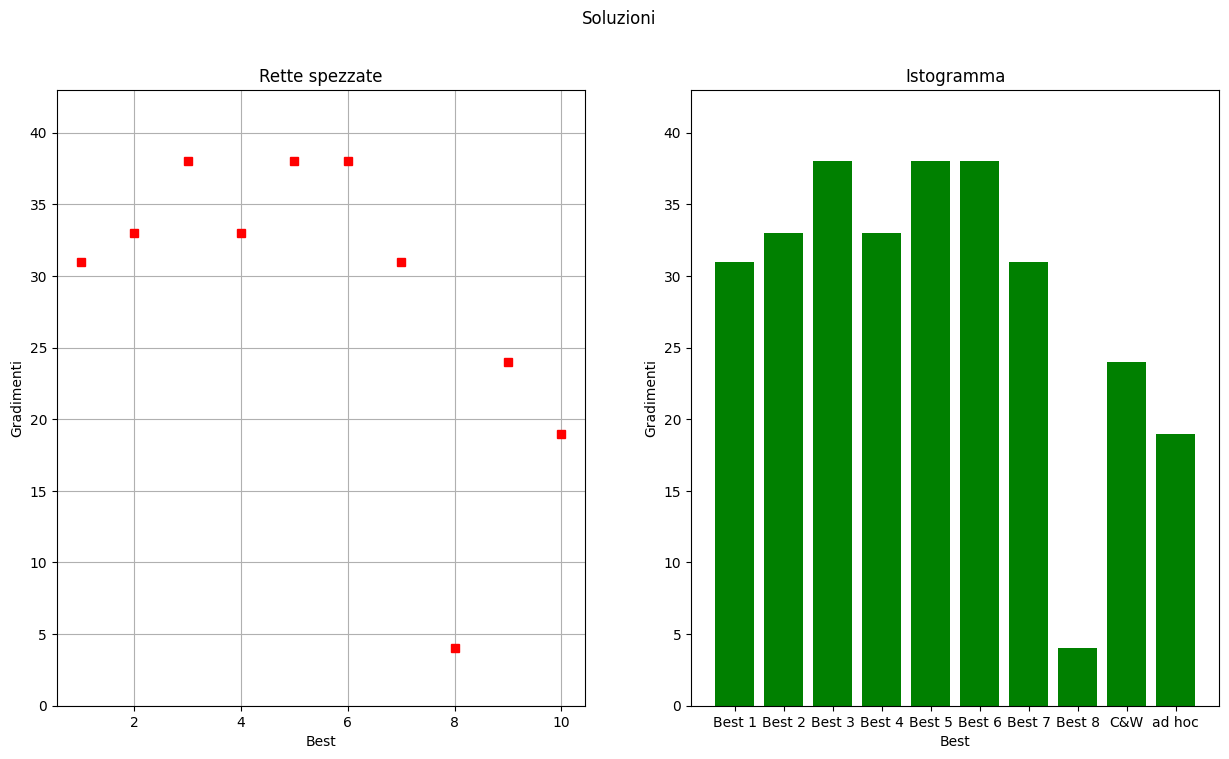

<Figure size 900x300 with 0 Axes>

['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


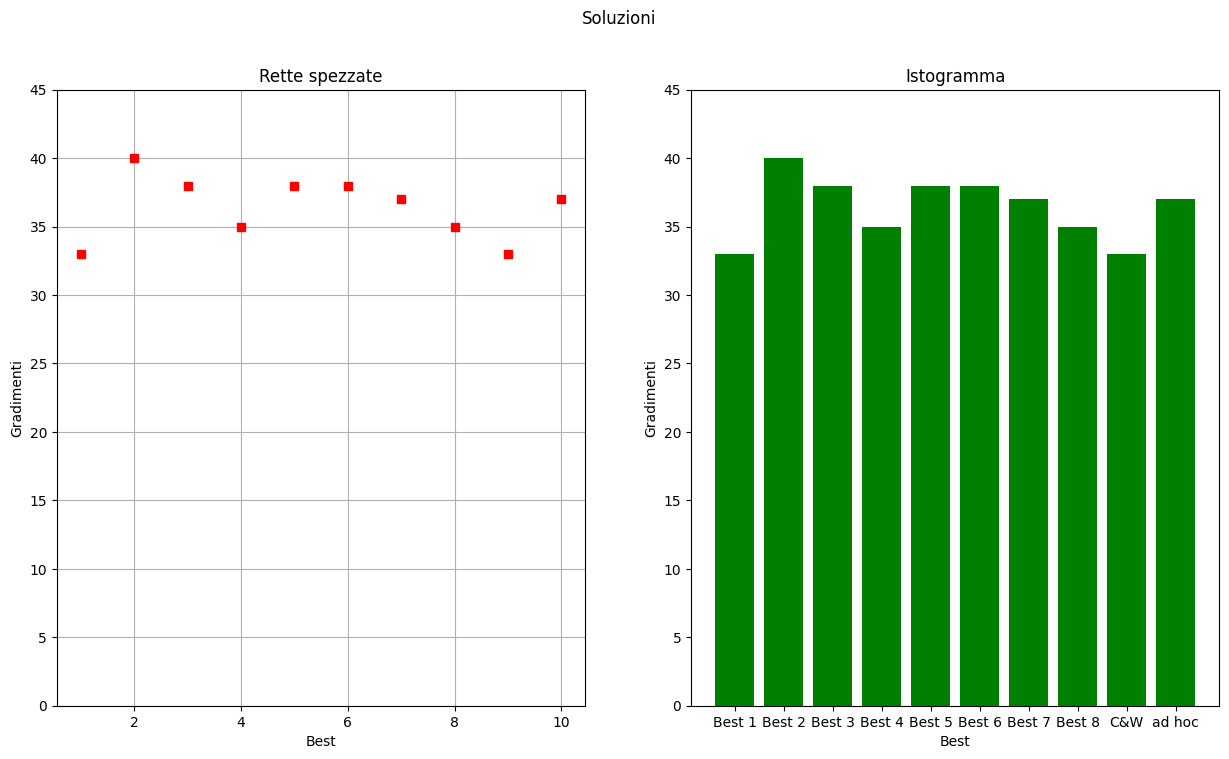

<Figure size 900x300 with 0 Axes>


-----------------------------------------------------------
i= 0

 
Hotel 0 0 0 480
Attr10 10 69 10 565
Attr8 8 0 9 581
Attr3 3 0 5 589
Attr6 6 0 3 608
Attr7 7 0 2 633
Attr9 9 0 2 643
Gradimento prima =  31



-----------------------------------------------------------

-----------------------------------------------------------
i= 1

 
Hotel 0 0 0 480
Attr1 1 0 2 487
Attr3 3 0 5 495
Attr7 7 70 2 590
Attr10 10 0 10 606
Attr6 6 0 3 625
Attr9 9 0 2 635
Attr8 8 0 9 651
Gradimento prima =  33



-----------------------------------------------------------

-----------------------------------------------------------
i= 2

 
Hotel 0 0 0 480
Attr6 6 0 3 499
Attr9 9 0 2 509
Attr8 8 0 9 525
Attr5 5 0 4 538
Attr2 2 0 1 550
Attr10 10 0 10 566
Attr1 1 0 2 573
Attr7 7 0 2 598
Attr3 3 0 5 606
Gradimento prima =  38



-----------------------------------------------------------

-----------------------------------------------------------
i= 3

 
Hotel 0 0 0 480
Attr10 10 69 10 565
Attr3 3 0 5 573
Att

In [27]:
L=[]
for key,value in attrazioni.items():
    L.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))

# lista di liste che conterrà tutte le soluzioni migliorate dalla Destroy and Repair
all_solutions_migliorate_DR_tabu = []
all_solutions_migliorate_gradimenti_tabu=[]

inizio=time.time()
for i in range(len(all_solutions)):
    (current_solution,ottimo_candidato) = destroy_and_repair_tabu_insertion(estrai_da_LL(all_solutions,i), L, i)

    all_solutions_migliorate_DR_tabu.append(ottimo_candidato)
    all_solutions_migliorate_gradimenti_tabu.append(calcola_gradimento_soluzione(ottimo_candidato))
tempo=(time.time()-inizio)*1000

tempi_esecuzione.append(tempo)
plot_gradimenti_greedy(all_solutions,all_gradimenti)
plot_gradimenti_greedy(all_solutions_migliorate_DR_tabu,all_solutions_migliorate_gradimenti_tabu)


for i in range(len(all_solutions)):
    print("\n-----------------------------------------------------------")
    print("i=",i)
    myprint("", all_solutions[i])
    print("Gradimento prima = ",calcola_gradimento_soluzione(all_solutions[i]))
    print("\n")

    print("\n-----------------------------------------------------------")

for i in range(len(all_solutions_migliorate_DR_tabu)):
    print("\n-----------------------------------------------------------")
    print("i=",i)
    myprint("all_solutions_migliorate_DR_tabu", all_solutions_migliorate_DR_tabu[i])
    print("\n")
    myprint("", all_solutions_migliorate_DR_tabu[i])
    print("Gradimento dopo = ",calcola_gradimento_soluzione(all_solutions_migliorate_DR_tabu[i]))

    print("\n-----------------------------------------------------------")

In [28]:
# ATTENZIONE AI PARAMETRI: SE SONO SBAGLIATI PUò ANDARE IN LOOP INFINITO
def destroy_and_repair_5_6_parametrica(soluzione_best, L, index, tipo_repair, criterio_repair, percentuale_distruzione):
    Temperatura = 100
    current_solution = clona_lista(soluzione_best)
    ottimo_candidato=clona_lista(soluzione_best)

    myprint("Current solution prima di iniziare", current_solution)
    print("best "+str(index))

    while(Temperatura > 0):# and not_in_soluzione):
        # serve per andare a memorizzare il massimo valore di attesa che troverò
        tmp_max_attesa = 0
        # id del nodo che avrà il massimo valore di attesa
        tmp_max_attesa_id = None
        # indice del nodo che avrà il max valore di attesa
        tmp_max_attesa_index = None

        tmp_node_greedy_5=None
        tmp_node_greedy_6=None
        tmp_ammissibility_check_5=False
        tmp_ammissibility_check_6=False

        # lista che memorizza i nodi dal primo fino a quello prima della "rottura" (escluso)
        da_tenere = []
        #lista che memorizza i nodi dal primo rotto (incluso) in poi
        distrutti = []

        #calcolo indice di distruzione
        indice_distruzione=math.floor(percentuale_distruzione*len(current_solution)) #arrotondamento per difetto
        #print("indice_distruzione=",indice_distruzione)

        # vado a cercare il nodo con il massimo valore di attesa e lo salvo nelle variabili temporanee
        for i in range(indice_distruzione, len(current_solution)):
            if current_solution[i].t_attesa > tmp_max_attesa:
                tmp_max_attesa = current_solution[i].t_attesa
                tmp_max_attesa_id = current_solution[i].id
                tmp_max_attesa_index = i

        #caso speciale: se tutte le attrazioni hanno attesa = 0
        #DA CAMBIARE: METTERE IL VALORE indice_distruzione AL POSTO DI FARE LA METà DELLA LISTA
        # distruggo tutti i nodi in cui gli ho dato il permesso di fare le modifiche
        # se cancello tutta la lista non è un problema perché tanto vado ad aggiungere l'hotel (caso già considerato)

        if (tmp_max_attesa == 0):
            tmp_max_attesa_index = indice_distruzione
            tmp_max_attesa_id = current_solution[tmp_max_attesa_index]
        # ora le mie variabili tmp rappresentano il nodo da rimuovere (da lì in poi)

####### Destroy #######


        for i in range(len(current_solution)):
            if (i < tmp_max_attesa_index):
                da_tenere.append(current_solution[i])
            else:
                distrutti.append(current_solution[i])

        not_in_soluzione = []
        for i in range(len(L)):
            if not_member(L[i],current_solution):
                not_in_soluzione.append(L[i])

        not_in_soluzione = clona_lista(not_in_soluzione+distrutti)

        #pulisco a priori i nodi che non posso visitare
        not_in_soluzione = pulizia_solo_ammissibilita([Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0)], not_in_soluzione)

        myprint("da_tenere", da_tenere)
        myprint("distrutti", distrutti)
        myprint("not_in_soluzione", not_in_soluzione)

####### Repair #######

        while(not_in_soluzione):

            # SE hai distrutto il nodo iniziale e la lista da_tenere è vuota
            # ALLORA sono nell'hotel
            if (len(da_tenere))==0:
                print("\nCASO SPECIALE: hai distrutto tutta la lista da_tenere")
                print("aggiungo l'hotel per non avere la lista vuota")
                da_tenere.append(Nodo(0,"Hotel",0,[(0,1440)],START,0,START,(0,1440),None,0))


            if tipo_repair == 2: #greedy 5 e 6 insieme con confronto
                print("\nStai facendo il repair usando la best_greedy_5 e la best_greedy_6 insieme\n")

                print("len(current_solution)=", len(current_solution))
                print("percentuale_distruzione*len(current_solution)=",percentuale_distruzione*len(current_solution))
                print("percentuale_distruzione=",percentuale_distruzione)
                print("indice_distruzione=",indice_distruzione)

                tmp_node_greedy_5 = best_greedy_5(not_in_soluzione, da_tenere[-1])[0]
                tmp_ammissibility_check_5, tmp_node_greedy_5_ammissibile = if_ammissible_get_node(da_tenere, tmp_node_greedy_5)

                tmp_list_greedy_6 = best_greedy_6(not_in_soluzione, da_tenere[-1], 3)
                if tmp_list_greedy_6 != None:
                    tmp_node_greedy_6 = tmp_list_greedy_6[0]
                    tmp_ammissibility_check_6, tmp_node_greedy_6_ammissibile = if_ammissible_get_node(da_tenere, tmp_node_greedy_6)
                else:
                    tmp_ammissibility_check_6 = False
                    tmp_node_greedy_6 = None

                # clono la lista da_tenere facendo una deep copy
                da_tenere_5 = clona_lista(da_tenere)
                da_tenere_6 = clona_lista(da_tenere)

                if tmp_ammissibility_check_5 == True:
                    print("Nodo estratto dalla greedy 5 e messo in append alla lista da_tenere_5 =", tmp_node_greedy_5_ammissibile.nome)
                    da_tenere_5.append(tmp_node_greedy_5_ammissibile)
                else:
                    print("Nodo estratto dalla greedy 5 ma scartato perché non ammissibile =", tmp_node_greedy_5.nome)

                if tmp_ammissibility_check_6 == True:
                    print("Nodo estratto dalla greedy 6 e messo in append alla lista da_tenere_6 =", tmp_node_greedy_6_ammissibile.nome)
                    da_tenere_6.append(tmp_node_greedy_6_ammissibile)
                else:
                    if tmp_node_greedy_6 != None:
                        print("Nodo estratto dalla greedy 6 ma scartato perché non ammissibile =", tmp_node_greedy_6.nome)
                    else:
                        print("Nodo estratto dalla greedy 6 ha dato come risultato None")

                # se la greedy_5 e la greedy_6 hanno dato nodi ammissibili allora cerca il migliore
                if tmp_ammissibility_check_5 == True and tmp_ammissibility_check_6 == True:
                    print("tmp_ammissibility_check_5 == True and tmp_ammissibility_check_6 == True")

                    if criterio_repair==0: #t_visita minore
                        print("Scelgo il nodo con il criterio: t_visita minore")
                        new_time_5 = da_tenere_5[-1].t_visita
                        new_time_6 = da_tenere_6[-1].t_visita

                        if new_time_5 < new_time_6:
                            print("Il t_visita dato dalla greedy 5 è meglio di quello dato dalla greedy 6")
                            da_tenere.append(tmp_node_greedy_5_ammissibile)
                            not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_5_ammissibile.id)
                        else:
                            print("Il t_visita dato dalla greedy 6 è meglio di quello dato dalla greedy 5")
                            da_tenere.append(tmp_node_greedy_6_ammissibile)
                            not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_6_ammissibile.id)

                    elif criterio_repair==1: #gradimento maggiore
                        print("Scelgo il nodo con il criterio: gradimento maggiore")
                        new_gradimento_5 = calcola_gradimento_soluzione(da_tenere_5)
                        new_gradimento_6 = calcola_gradimento_soluzione(da_tenere_6)

                        if new_gradimento_5 > new_gradimento_6:
                        #if new_time_5 < new_time_6:
                            print("Il gradimento dato dalla greedy 5 è meglio di quello dato dalla greedy 6")
                            da_tenere.append(tmp_node_greedy_5_ammissibile)
                            not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_5_ammissibile.id)
                        else:
                            print("Il gradimento dato dalla greedy 6 è meglio di quello dato dalla greedy 5")
                            da_tenere.append(tmp_node_greedy_6_ammissibile)
                            not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_6_ammissibile.id)

                # se una delle due greedy non ha dato un nodo ammissibile devo capire chi è
                else:
                    # se la greedy 5 è ammissibile allora quella non ammissibile era la 6
                    if tmp_ammissibility_check_5 == True:
                        print("tmp_ammissibility_check_5 == True")
                        da_tenere.append(tmp_node_greedy_5_ammissibile)
                        not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_5_ammissibile.id)

                    else:
                        # se la greedy 5 è non è ammissibile allora controlliamo la 6
                        if tmp_ammissibility_check_6 == True:
                            print("tmp_ammissibility_check_6 == True")
                            da_tenere.append(tmp_node_greedy_6_ammissibile)
                            not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_6_ammissibile.id)
                        else:
                            # se nessuna delle due produce una soluzione ammissibile allora tolgo i nodi e basta
                            print("tmp_ammissibility_check_5 e tmp_ammissibility_check_6 sono entrambe non True")
                            not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_5.id)
                            if tmp_node_greedy_6 != None:
                                not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_6.id)

            elif tipo_repair == 1: #solo best_6
                print("\nStai facendo il repair usando solo la best_greedy_6\n")

                print("len(current_solution)=", len(current_solution))
                print("percentuale_distruzione*len(current_solution)=",percentuale_distruzione*len(current_solution))
                print("percentuale_distruzione=",percentuale_distruzione)
                print("indice_distruzione=",indice_distruzione)

                tmp_list_greedy_6 = best_greedy_6(not_in_soluzione, da_tenere[-1], 3)
                if tmp_list_greedy_6 != None:
                    tmp_node_greedy_6 = tmp_list_greedy_6[0]
                    tmp_ammissibility_check_6, tmp_node_greedy_6_ammissibile = if_ammissible_get_node(da_tenere, tmp_node_greedy_6)
                else:
                    tmp_ammissibility_check_6 = False
                    tmp_node_greedy_6 = None

                if tmp_ammissibility_check_6 == True:
                    print("Nodo estratto dalla greedy 6 e messo in append alla lista da_tenere =", tmp_node_greedy_6_ammissibile.nome)
                    da_tenere.append(tmp_node_greedy_6_ammissibile)
                    not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_6_ammissibile.id)
                else:
                    if tmp_node_greedy_6 != None:
                        print("Nodo estratto dalla greedy 6 ma scartato perché non ammissibile =", tmp_node_greedy_6.nome)
                        not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_6.id)
                    else:
                        print("Nodo estratto dalla greedy 6 ha dato come risultato None")

            elif tipo_repair == 0: #solo best_5
                print("\nStai facendo il repair usando solo la best_greedy_5\n")

                print("len(current_solution)=", len(current_solution))
                print("percentuale_distruzione*len(current_solution)=",percentuale_distruzione*len(current_solution))
                print("percentuale_distruzione=",percentuale_distruzione)
                print("indice_distruzione=",indice_distruzione)

                tmp_node_greedy_5 = best_greedy_5(not_in_soluzione, da_tenere[-1])[0]
                tmp_ammissibility_check_5, tmp_node_greedy_5_ammissibile = if_ammissible_get_node(da_tenere, tmp_node_greedy_5)

                if tmp_ammissibility_check_5 == True:
                    print("Nodo estratto dalla greedy 5 e messo in append alla lista da_tenere =", tmp_node_greedy_5_ammissibile.nome)
                    da_tenere.append(tmp_node_greedy_5_ammissibile)
                    not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_5_ammissibile.id)
                else:
                    print("Nodo estratto dalla greedy 5 ma scartato perché non ammissibile =", tmp_node_greedy_5.nome)
                    not_in_soluzione = remove_nodo_by_id(not_in_soluzione, tmp_node_greedy_5.id)

##################################################################################################################
            not_in_soluzione= clona_lista(pulizia_solo_ammissibilita(da_tenere, not_in_soluzione))
            myprint("not_in_soluzione dopo la pulizia", not_in_soluzione)
            myprint("da_tenere dopo un ciclo di REPAIR", da_tenere)

        # arrivati a questo punto nella lista da_tenere ho il meglio del meglio trovato usando le due best in maniera combinata
        new_gradimento = calcola_gradimento_soluzione(da_tenere)
        old_gradimento = calcola_gradimento_soluzione(current_solution)

        print("new_gradimento", new_gradimento)
        print("old_gradimento", old_gradimento)

        if (new_gradimento > old_gradimento):
            current_solution = clona_lista(da_tenere)
            ottimo_candidato=clona_lista(current_solution)
            print("Ho modificato la soluzione corrente perché la nuova era meglio della vecchia")
        else:
            print("Non ho modificato la soluzione corrente perché la nuova era peggio della vecchia")

############# simulated annealing #############

            print("Sono nel simulated annealing")
            r = random.uniform(0,1)
            print("r=",r)
            deltaE = old_gradimento - new_gradimento
            print("Delta E=", deltaE)
            print("Delta E / Temperatura=", deltaE/Temperatura)

            e = math.exp(-deltaE/Temperatura)
            print("e = ", e)
            if (r > e):
                print("Accetto il peggioramento della soluzione")
                current_solution = clona_lista(da_tenere)
            else:
                print("Non accetto il peggioramento della soluzione (simulated annealing)")

        Temperatura = Temperatura - random.randint(1,5)
        #Temperatura = Temperatura - 30 #test
        print("\n\n\nTemperatura=", Temperatura)
    print("Ultima istruzione prima del return")
    return current_solution,ottimo_candidato

Output streaming troncato alle ultime 5000 righe.
Attr3 3 0 5 596
Attr6 6 0 3 623
Attr7 7 0 2 646
Attr9 9 0 2 666
new_gradimento 31
old_gradimento 31
Non ho modificato la soluzione corrente perché la nuova era peggio della vecchia
Sono nel simulated annealing
r= 0.8072048346269723
Delta E= 0
Delta E / Temperatura= 0.0
e =  1.0
Non accetto il peggioramento della soluzione (simulated annealing)



Temperatura= 53

 da_tenere
Attr10 10 69 10 565
Attr8 8 0 9 584

 distrutti
Attr3 3 0 5 596
Attr6 6 0 3 623
Attr7 7 0 2 646
Attr9 9 0 2 666

 not_in_soluzione
Attr1 1 0 2 480
Attr2 2 0 1 480
Attr4 4 0 4 480
Attr5 5 0 4 480
Attr3 3 0 5 596
Attr6 6 0 3 623
Attr7 7 0 2 646
Attr9 9 0 2 666

Stai facendo il repair usando la best_greedy_5 e la best_greedy_6 insieme

len(current_solution)= 6
percentuale_distruzione*len(current_solution)= 2.0999999999999996
percentuale_distruzione= 0.35
indice_distruzione= 2
len(sorted_attrazioni)= 7
N passato come parametro= 3
N dopo il max(N, math.floor(len(sorted_at

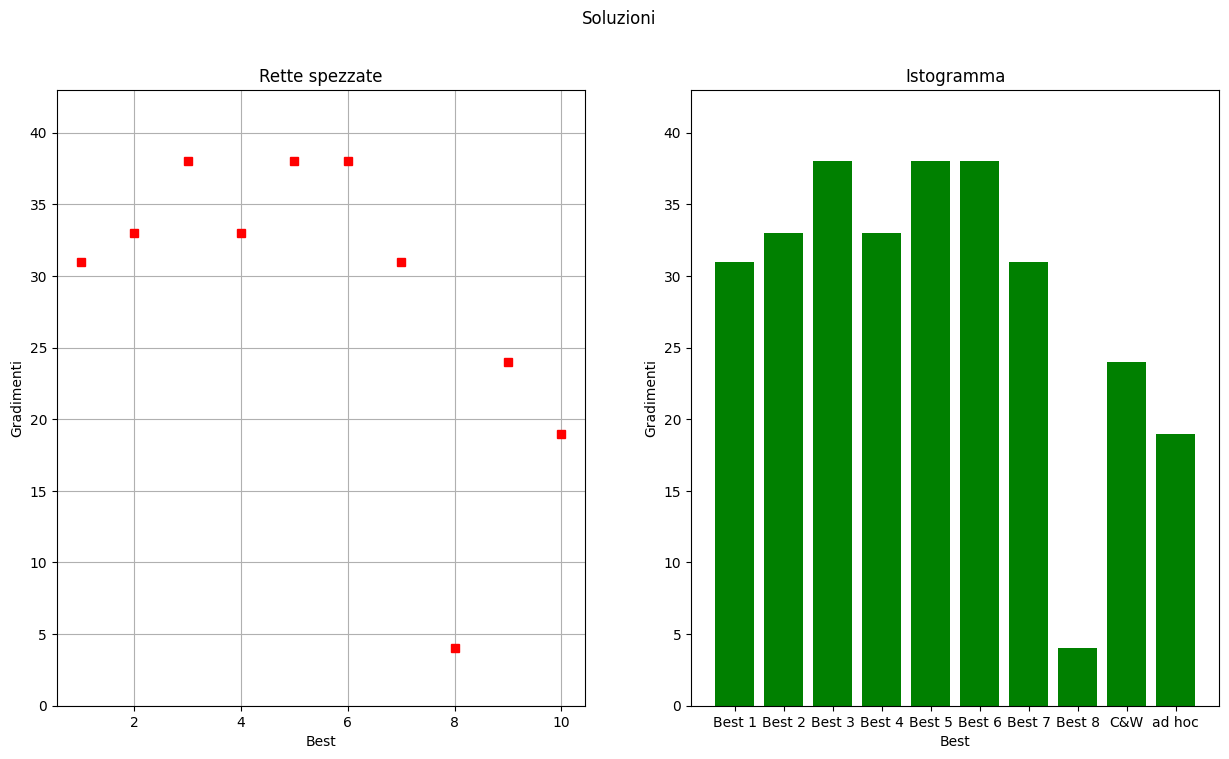

<Figure size 900x300 with 0 Axes>

['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc', 'Best 11', 'Best 12', 'Best 13', 'Best 14', 'Best 15', 'Best 16', 'Best 17', 'Best 18', 'Best 19', 'Best 20', 'Best 21', 'Best 22', 'Best 23', 'Best 24', 'Best 25', 'Best 26', 'Best 27', 'Best 28', 'Best 29', 'Best 30', 'Best 31', 'Best 32', 'Best 33', 'Best 34', 'Best 35', 'Best 36', 'Best 37', 'Best 38', 'Best 39', 'Best 40', 'Best 41', 'Best 42', 'Best 43', 'Best 44', 'Best 45', 'Best 46', 'Best 47', 'Best 48', 'Best 49', 'Best 50', 'Best 51', 'Best 52', 'Best 53', 'Best 54', 'Best 55', 'Best 56', 'Best 57', 'Best 58', 'Best 59', 'Best 60', 'Best 61', 'Best 62', 'Best 63', 'Best 64', 'Best 65', 'Best 66', 'Best 67', 'Best 68', 'Best 69', 'Best 70', 'Best 71', 'Best 72', 'Best 73', 'Best 74', 'Best 75', 'Best 76', 'Best 77', 'Best 78', 'Best 79', 'Best 80', 'Best 81', 'Best 82', 'Best 83', 'Best 84', 'Best 85', 'Best 86', 'Best 87', 'Best 88', 'Best 89', 'Best 90', 'Best 91', 'Best 92', 

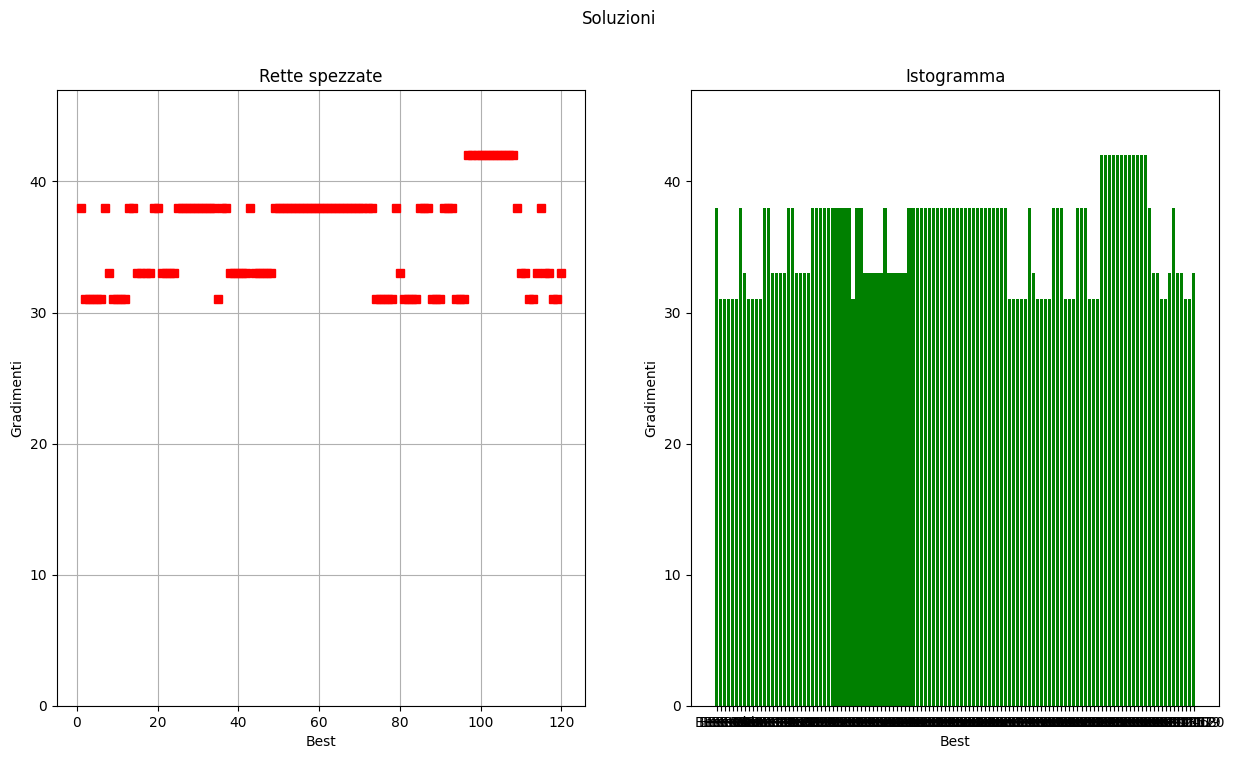

<Figure size 900x300 with 0 Axes>


-----------------------------------------------------------
i= 0

 
Hotel 0 0 0 480
Attr10 10 69 10 565
Attr8 8 0 9 581
Attr3 3 0 5 589
Attr6 6 0 3 608
Attr7 7 0 2 633
Attr9 9 0 2 643
Gradimento prima =  31



-----------------------------------------------------------

-----------------------------------------------------------
i= 1

 
Hotel 0 0 0 480
Attr1 1 0 2 487
Attr3 3 0 5 495
Attr7 7 70 2 590
Attr10 10 0 10 606
Attr6 6 0 3 625
Attr9 9 0 2 635
Attr8 8 0 9 651
Gradimento prima =  33



-----------------------------------------------------------

-----------------------------------------------------------
i= 2

 
Hotel 0 0 0 480
Attr6 6 0 3 499
Attr9 9 0 2 509
Attr8 8 0 9 525
Attr5 5 0 4 538
Attr2 2 0 1 550
Attr10 10 0 10 566
Attr1 1 0 2 573
Attr7 7 0 2 598
Attr3 3 0 5 606
Gradimento prima =  38



-----------------------------------------------------------

-----------------------------------------------------------
i= 3

 
Hotel 0 0 0 480
Attr10 10 69 10 565
Attr3 3 0 5 573
Att

In [29]:
improved_solutions= []
improved_gradimenti=[]

L=[]
for key,value in attrazioni.items():
    L.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))

myprint("Lista di attrazioni = ",L)

all_parameters=[{"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                {"best":estrai_da_LL(all_solutions,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},
                ]

# lista di liste che conterrà tutte le soluzioni migliorate dalla Destroy and Repair
all_solutions_migliorate_DR_parametrica = []
all_solutions_migliorate_gradimenti=[]

inizio=time.time()
for i in range(len(all_parameters)):
    (current_solution,ottimo_candidato) = destroy_and_repair_5_6_parametrica(all_parameters[i]["best"],all_parameters[i]["attrazioni"],all_parameters[i]["index"],all_parameters[i]["tipo_repair"],all_parameters[i]["criterio_repair"],all_parameters[i]["percentuale_distruzione"])

    all_solutions_migliorate_DR_parametrica.append(ottimo_candidato)
    all_solutions_migliorate_gradimenti.append(calcola_gradimento_soluzione(ottimo_candidato))
tempo=(time.time()-inizio)*1000

tempi_esecuzione.append(tempo)
plot_gradimenti_greedy(all_solutions,all_gradimenti)
plot_gradimenti_greedy(all_solutions_migliorate_DR_parametrica,all_solutions_migliorate_gradimenti)


for i in range(len(all_solutions)):
    print("\n-----------------------------------------------------------")
    print("i=",i)
    myprint("", all_solutions[i])
    print("Gradimento prima = ",calcola_gradimento_soluzione(all_solutions[i]))
    print("\n")

    print("\n-----------------------------------------------------------")

for i in range(len(all_solutions_migliorate_DR_parametrica)):
    print("\n-----------------------------------------------------------")
    print("i=",i)
    myprint("all_solutions_migliorate_DR_parametrica", all_solutions_migliorate_DR_parametrica[i])
    print("\n")
    myprint("", all_solutions_migliorate_DR_parametrica[i])
    print("Gradimento dopo = ",calcola_gradimento_soluzione(all_solutions_migliorate_DR_parametrica[i]))

    print("\n-----------------------------------------------------------")

In [30]:
# funzione che prende in ingresso una lista di soluzioni (quindi una lista di liste) e poi mi restituisce la soluzione che ha il gradimento massimo
def migliori_migliorate(lista_miglioramenti):
    tmp_gradimento_max = 0
    tmp_migliore_soluzione=[]

    for i in range(len(lista_miglioramenti)):
        tmp_gradimento = calcola_gradimento_soluzione(lista_miglioramenti[i])
        if tmp_gradimento > tmp_gradimento_max:
            tmp_gradimento_max = tmp_gradimento
            tmp_migliore_soluzione = clona_lista(lista_miglioramenti[i])

    return tmp_migliore_soluzione




------------------------------------------------------------

Soluzione i= 1
Tentativo di miglioramento numero j= 1

 
Hotel 0 0 0 480
Attr1 1 0 2 487
Attr3 3 0 5 498
Attr9 9 0 2 524
Attr2 2 0 1 543
Attr5 5 0 4 565
Attr10 10 0 10 576
Attr8 8 0 9 595
Attr6 6 0 3 622
Attr7 7 0 2 645
Gradimento= 38
------------------------------------------------------------


------------------------------------------------------------

Soluzione i= 1
Tentativo di miglioramento numero j= 2

 
Attr10 10 69 10 565
Attr8 8 0 9 581
Attr3 3 0 5 589
Attr6 6 0 3 608
Attr7 7 0 2 633
Attr9 9 0 2 643
Gradimento= 31
------------------------------------------------------------


------------------------------------------------------------

Soluzione i= 1
Tentativo di miglioramento numero j= 3

 
Attr10 10 69 10 565
Attr8 8 0 9 581
Attr3 3 0 5 589
Attr6 6 0 3 608
Attr7 7 0 2 633
Attr9 9 0 2 643
Gradimento= 31
------------------------------------------------------------


---------------------------------------------

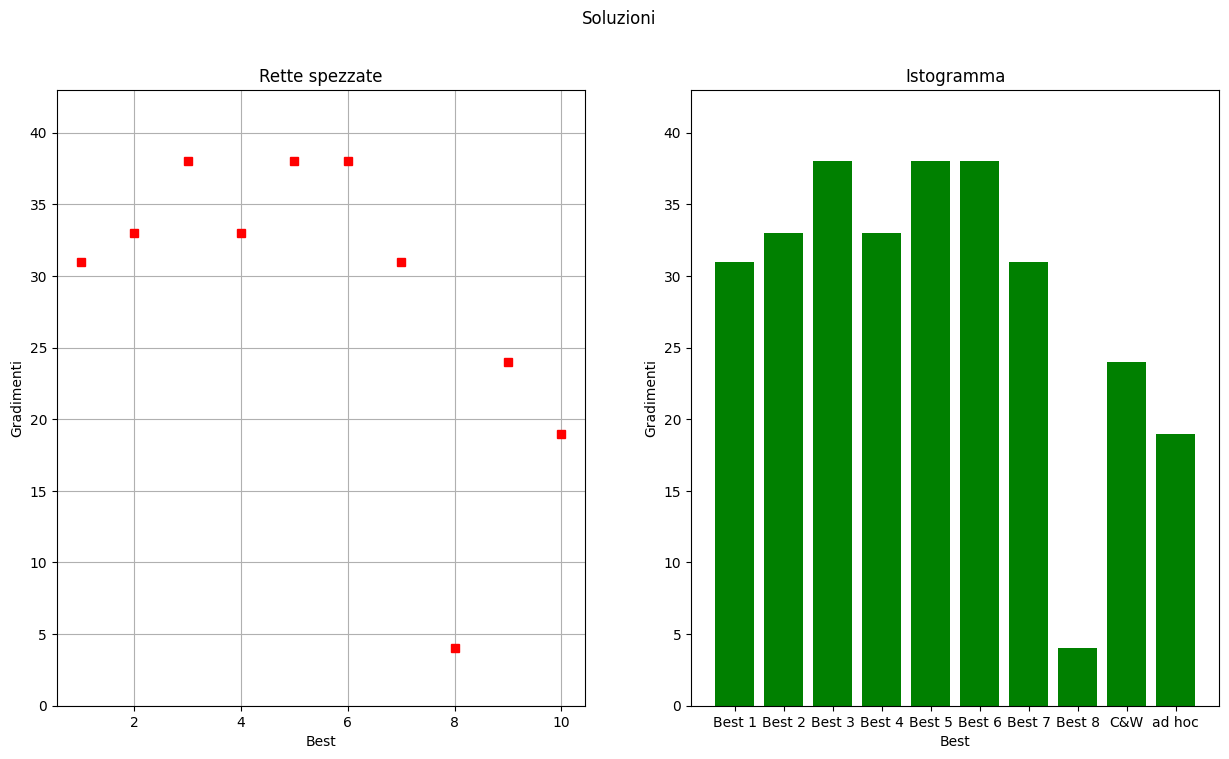

<Figure size 900x300 with 0 Axes>

['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


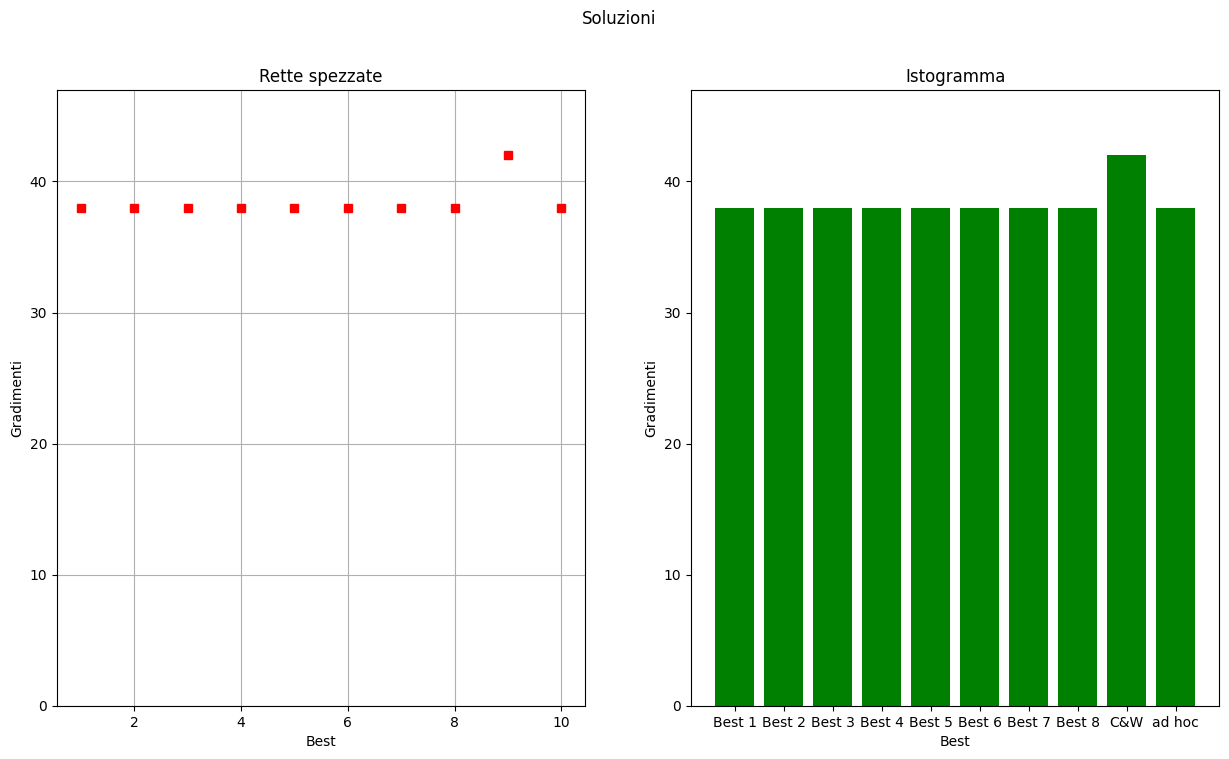

<Figure size 900x300 with 0 Axes>

In [31]:
# all_solutions_migliorate_DR_parametrica è una lista di liste di liste(???) che contiene tutti i 120 tentativi di miglioramento
all_solutions_migliorate_DR_parametrica_raggruppate=[]

numero_sottoliste = 10 # numero di best date come input al miglioramento
lunghezza_sottoliste = 12 # numero di algoritmi di miglioramento utilizzati

all_solutions_migliorate_DR_parametrica_raggruppate = [all_solutions_migliorate_DR_parametrica[i:i+lunghezza_sottoliste] for i in range(0, len(all_solutions_migliorate_DR_parametrica), lunghezza_sottoliste)]

migliori_miglioramenti_DR_parametrica = [] # lista che contiene le 10 soluzioni migliorate migliori (una per ogni soluzione data in ingresso)
gradimenti_migliori_miglioramenti_DR_parametrica=[]

for i in range(len(all_solutions_migliorate_DR_parametrica_raggruppate)):

    migliori_miglioramenti_DR_parametrica.append(migliori_migliorate(all_solutions_migliorate_DR_parametrica_raggruppate[i]))
    gradimenti_migliori_miglioramenti_DR_parametrica.append(calcola_gradimento_soluzione(migliori_miglioramenti_DR_parametrica[-1]))

    for j in range(len(all_solutions_migliorate_DR_parametrica_raggruppate[i])):
        print("\n------------------------------------------------------------")
        print("\nSoluzione i=",i+1)
        print("Tentativo di miglioramento numero j=",j+1)
        myprint("",all_solutions_migliorate_DR_parametrica_raggruppate[i][j])
        print("Gradimento=", calcola_gradimento_soluzione(all_solutions_migliorate_DR_parametrica_raggruppate[i][j]))
        print("------------------------------------------------------------\n")


plot_gradimenti_greedy(all_solutions,all_gradimenti)
plot_gradimenti_greedy(migliori_miglioramenti_DR_parametrica,gradimenti_migliori_miglioramenti_DR_parametrica)

In [32]:
def plot_tempi(tempi_esecuzione,names,y_lim,unit,scarto):
    fig, ax=plt.subplots(figsize=(8,6))
    #fig.suptitle('Soluzioni')
    ax.bar(names,tempi_esecuzione,color=['blue'])
    ax.set_title('Istogramma')
    ax.set_ylim([0,y_lim+scarto])
    ax.set_xlabel('Algoritmi')
    ax.set_ylabel('Tempi esecuzione '+str(unit))

    plt.show()


Tempi esecuzione
Best 1 0.12731552124023438 ms
Best 2 0.11706352233886719 ms
Best 3 0.11134147644042969 ms
Best 4 0.11372566223144531 ms
Best 5 0.08916854858398438 ms
Best 6 0.22172927856445312 ms
Best 7 1.1911392211914062 ms
Best 8 0.21266937255859375 ms
Best 9 2.0477771759033203 ms
Best 10 5.739688873291016 ms
Best 11 61199.06663894653 ms
Best 12 489600.77953338623 ms


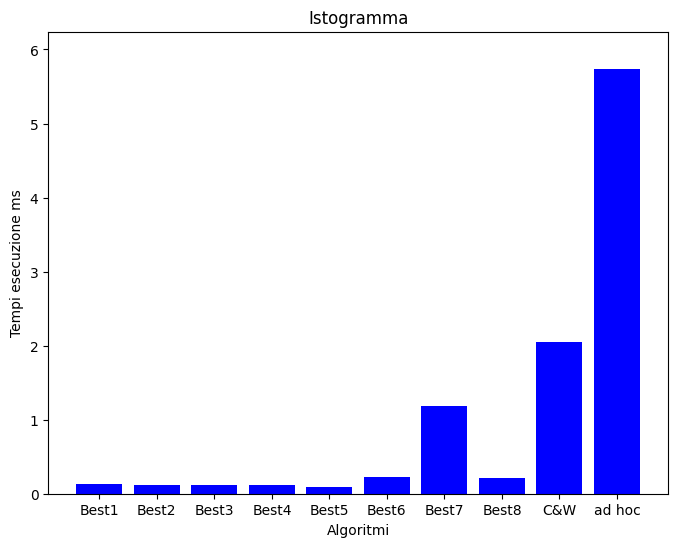

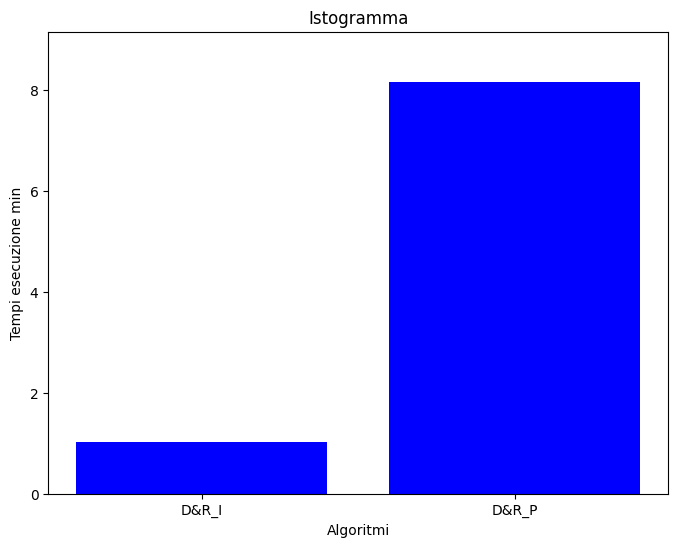

In [33]:
print('Tempi esecuzione')
for i in range(len(tempi_esecuzione)):
    print('Best '+ str(i+1)+ " "+str(tempi_esecuzione[i])+ " ms")

plot_tempi(tempi_esecuzione[:len(tempi_esecuzione)-2],["Best1","Best2","Best3","Best4","Best5","Best6","Best7","Best8","C&W","ad hoc"],max(tempi_esecuzione[:len(tempi_esecuzione)-2]),"ms",0.5)
print('\n')
tempi_ms=tempi_esecuzione[len(tempi_esecuzione)-2:]
tempi_minuti=list(map(lambda x: x/60000, tempi_ms))


plot_tempi(tempi_minuti,["D&R_I","D&R_P"],max(tempi_minuti),"min",1)


In [34]:
#####################################################################################################################################
###################################################        PARTE  NUOVA            ##################################################
#####################################################################################################################################

In [35]:
#prendo l'output della Destroy&Repair Insertion e lo inserisco dentro la Destroy&Repair Parametrica
DRI_in_DRP = []
gradimenti_DRI_in_DRP = []


L=[]
for key,value in attrazioni.items():
    L.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))

myprint("Lista di attrazioni = ",L)


all_parameters_insertion = [{"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,0),"attrazioni":L,"index":0,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,1),"attrazioni":L,"index":1,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,2),"attrazioni":L,"index":2,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,3),"attrazioni":L,"index":3,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,4),"attrazioni":L,"index":4,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,5),"attrazioni":L,"index":5,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,6),"attrazioni":L,"index":6,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,7),"attrazioni":L,"index":7,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,8),"attrazioni":L,"index":8,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},

                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":0,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":1,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":0,"percentuale_distruzione":0.80},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.00},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.35},
                            {"best":estrai_da_LL(all_solutions_migliorate_DR_tabu,9),"attrazioni":L,"index":9,"tipo_repair":2,"criterio_repair":1,"percentuale_distruzione":0.80},
                            ]


inizio=time.time()
for i in range(len(all_parameters_insertion)):
    (current_solution,ottimo_candidato) = destroy_and_repair_5_6_parametrica(all_parameters_insertion[i]["best"],all_parameters_insertion[i]["attrazioni"],all_parameters_insertion[i]["index"],all_parameters_insertion[i]["tipo_repair"],all_parameters_insertion[i]["criterio_repair"],all_parameters_insertion[i]["percentuale_distruzione"])

    DRI_in_DRP.append(ottimo_candidato)
    gradimenti_DRI_in_DRP.append(calcola_gradimento_soluzione(ottimo_candidato))

tempo=(time.time()-inizio)*1000
tempi_esecuzione.append(tempo)


print("\n\n\n\n\n")



# DRI_in_DRP è una lista di liste di liste che contiene tutti i 120 tentativi di miglioramento
DRI_in_DRP_raggruppate=[]
numero_sottoliste = 10 # numero di best date come input al miglioramento
lunghezza_sottoliste = 12 # numero di algoritmi di miglioramento utilizzati
DRI_in_DRP_raggruppate = [DRI_in_DRP[i:i+lunghezza_sottoliste] for i in range(0, len(DRI_in_DRP), lunghezza_sottoliste)]

migliori_miglioramenti_DRI_in_DRP = [] # lista che contiene le 10 soluzioni migliorate migliori (una per ogni soluzione data in ingresso)
gradimenti_migliori_miglioramenti_DRI_in_DRP=[]

for i in range(len(DRI_in_DRP_raggruppate)):

    migliori_miglioramenti_DRI_in_DRP.append(migliori_migliorate(DRI_in_DRP_raggruppate[i]))
    gradimenti_migliori_miglioramenti_DRI_in_DRP.append(calcola_gradimento_soluzione(migliori_miglioramenti_DRI_in_DRP[-1]))

    for j in range(len(DRI_in_DRP_raggruppate[i])):
        print("\n------------------------------------------------------------")
        print("\nSoluzione i=",i+1)
        print("Tentativo di miglioramento numero j=",j+1)
        myprint("",DRI_in_DRP_raggruppate[i][j])
        print("Gradimento=", calcola_gradimento_soluzione(DRI_in_DRP_raggruppate[i][j]))
        print("------------------------------------------------------------\n")


#plot_gradimenti_greedy(all_solutions,all_gradimenti)
#plot_gradimenti_greedy(migliori_miglioramenti_DRI_in_DRP,gradimenti_migliori_miglioramenti_DRI_in_DRP)




Output streaming troncato alle ultime 5000 righe.
 not_in_soluzione
Attr2 2 0 1 480
Attr4 4 0 4 480
Attr7 7 3 2 610

Stai facendo il repair usando la best_greedy_5 e la best_greedy_6 insieme

len(current_solution)= 8
percentuale_distruzione*len(current_solution)= 2.8
percentuale_distruzione= 0.35
indice_distruzione= 2
len(sorted_attrazioni)= 2
N passato come parametro= 3
N dopo il max(N, math.floor(len(sorted_attrazioni)*percentuale_random)) =  3
N prima di chiamare la funzione di scelta random = 2
Nodo estratto dalla greedy 5 e messo in append alla lista da_tenere_5 = Attr7
Nodo estratto dalla greedy 6 ma scartato perché non ammissibile = Attr4
tmp_ammissibility_check_5 == True

 not_in_soluzione dopo la pulizia

 da_tenere dopo un ciclo di REPAIR
Attr10 10 69 10 565
Attr3 3 0 5 508
Attr1 1 0 2 519
Attr8 8 0 9 544
Attr5 5 0 4 557
Attr6 6 0 3 572
Attr9 9 0 2 587
Attr7 7 3 2 610
new_gradimento 37
old_gradimento 37
Non ho modificato la soluzione corrente perché la nuova era peggio della 

Output streaming troncato alle ultime 5000 righe.
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271
Attr10 10 0 10 271

 lista_sx
Hotel 0 0 0 480
Attr2 2 0 1 231
Attr7 7 0 2 243
Attr5 5 0 4 260

 lista_dx
Attr4 4 0 4 301
Attr6 6 35 3 365
Attr9 9 15 2 395
Attr1 1 27 2 429
Attr3 3 25 5 465
Attr8 8 10 9 487
Hotel 0 0 0 503

 not_in_soluzione

 first_list
Hotel 0 0 0 480
Attr2 2 0 1 231
Attr7 7 0 2 243
Attr5 5 0 4 260

 second_list
Attr4 4 0 4 301
Attr6 6 35 3 365
Attr9 9 15 2 395
Attr1 1 27 2 429
Attr3 3 25 5 465
Attr8 8 10 9 487
Hotel 0 0 0 503
Sono il nodo= Hotel
t_arrivo= 480
t_visita= 480
tw= (0, 1440)
So

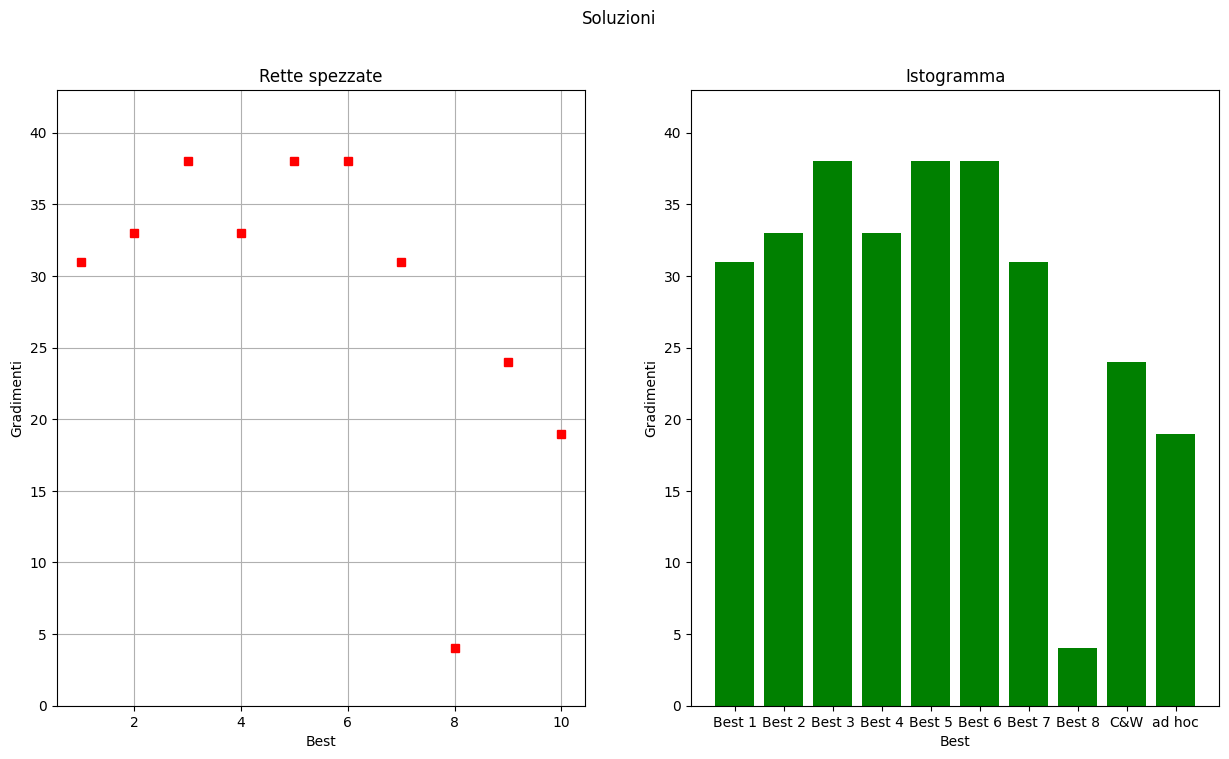

<Figure size 900x300 with 0 Axes>

['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


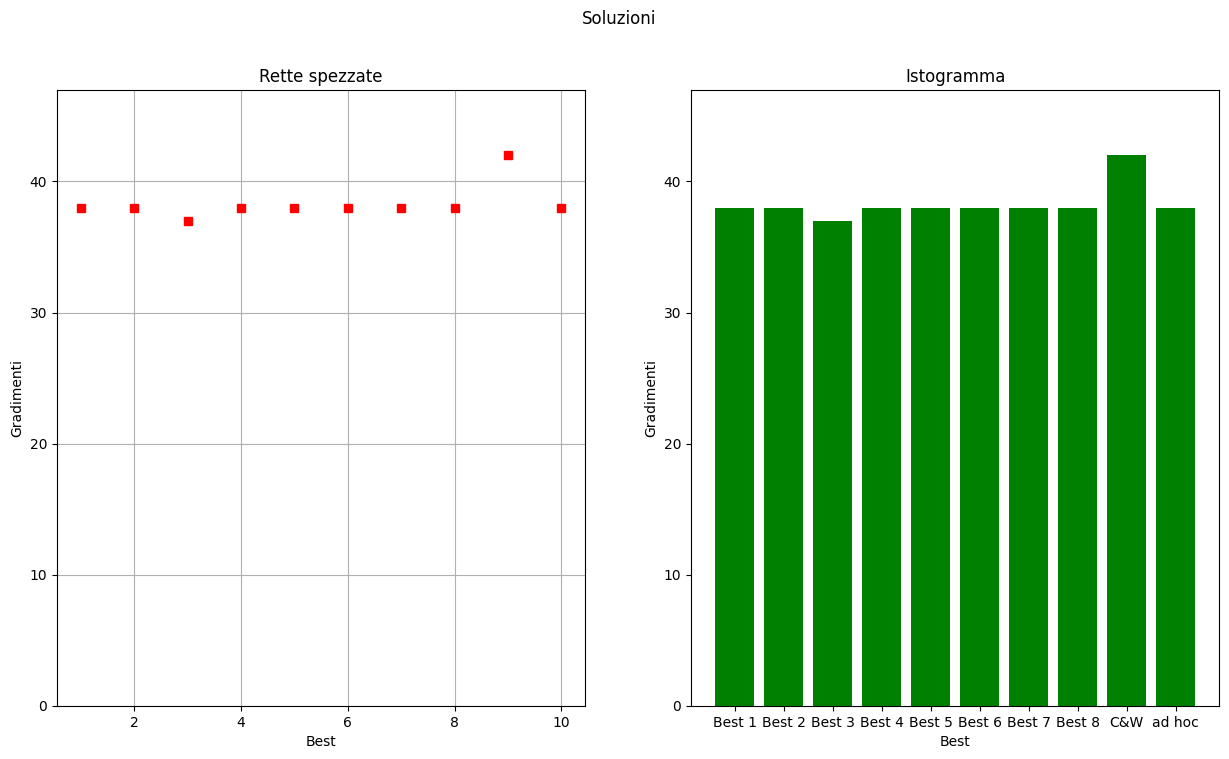

<Figure size 900x300 with 0 Axes>

In [36]:
#prendo l'output della Destroy&Repair Parametrica e lo inserisco dentro la Destroy&Repair Insertion

L=[]
for key,value in attrazioni.items():
    L.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))

# lista di liste che conterrà tutte le soluzioni migliorate dalla Destroy and Repair
DRP_in_DRI = []
gradimenti_DRP_in_DRI=[]

inizio=time.time()
for i in range(len(migliori_miglioramenti_DR_parametrica)):
    (current_solution,ottimo_candidato) = destroy_and_repair_tabu_insertion(estrai_da_LL(migliori_miglioramenti_DR_parametrica,i), L, i)

    DRP_in_DRI.append(ottimo_candidato)
    gradimenti_DRP_in_DRI.append(calcola_gradimento_soluzione(ottimo_candidato))
tempo=(time.time()-inizio)*1000

tempi_esecuzione.append(tempo)
plot_gradimenti_greedy(all_solutions,all_gradimenti)
plot_gradimenti_greedy(DRP_in_DRI,gradimenti_DRP_in_DRI)

In [37]:
def print_soluzione(soluzione):
    print("\nSOLUZIONE MIGLIORE")
    tmp="[ "
    for i in range(len(soluzione)):
        if soluzione[i].id!=0:
            tmp += str(soluzione[i].nome) + " "
    tmp +="]"
    print(tmp)
    print("\n")


#print_soluzione(all_solutions[0])

In [38]:
#####################################################################################################################################
############################                                   PLOT TEMPI                               #############################
#####################################################################################################################################

seed = 42
numero_di_attrazioni = 10
numero minimo di tw per ogni attrazione = 1
numero massimo di tw per ogni attrazione = 4
durata tour = 300
range per le distanze casuali: D_MIN = 5  D_MAX = 30
somma dei gradimenti di tutte le attrazioni = 42

 all_solutions,all_gradimenti
['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


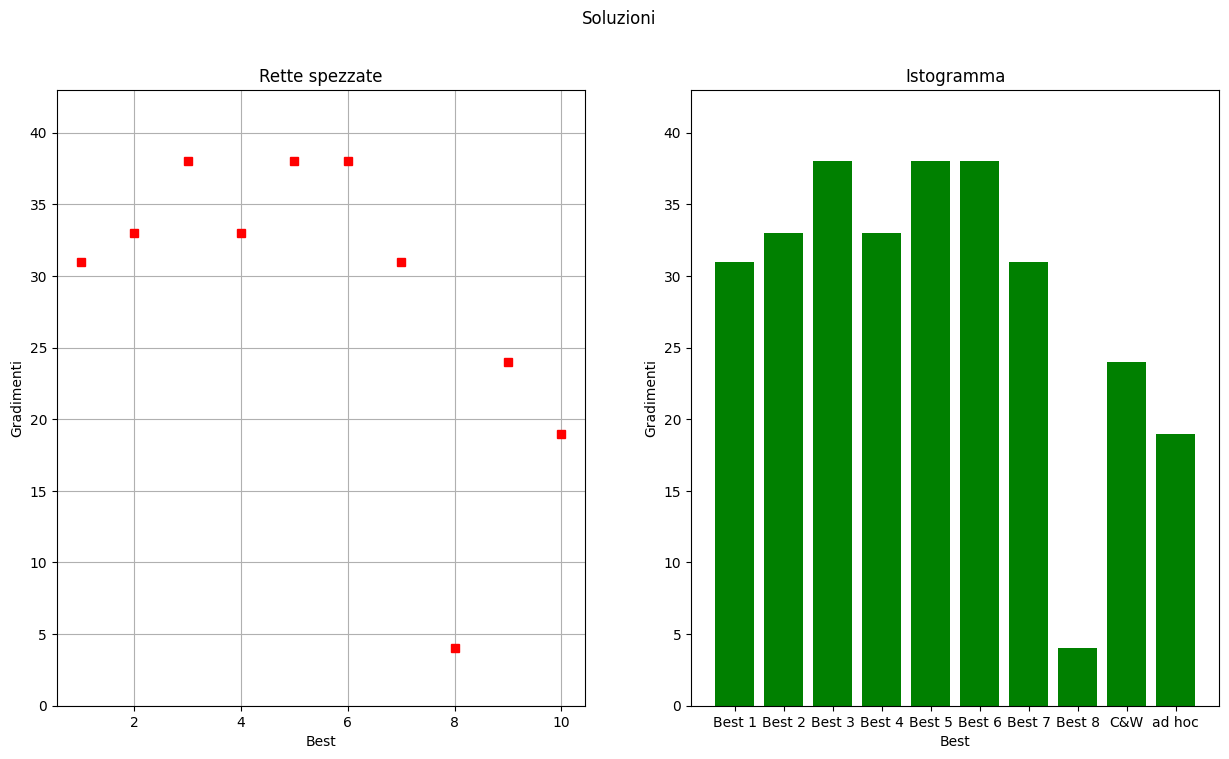

<Figure size 900x300 with 0 Axes>


SOLUZIONE MIGLIORE
[ Attr6 Attr9 Attr8 Attr5 Attr2 Attr10 Attr1 Attr7 Attr3 ]


gradimento = 38

#######################################################################


 all_solutions_migliorate_DR_parametrica, all_solutions_migliorate_gradimenti
['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc', 'Best 11', 'Best 12', 'Best 13', 'Best 14', 'Best 15', 'Best 16', 'Best 17', 'Best 18', 'Best 19', 'Best 20', 'Best 21', 'Best 22', 'Best 23', 'Best 24', 'Best 25', 'Best 26', 'Best 27', 'Best 28', 'Best 29', 'Best 30', 'Best 31', 'Best 32', 'Best 33', 'Best 34', 'Best 35', 'Best 36', 'Best 37', 'Best 38', 'Best 39', 'Best 40', 'Best 41', 'Best 42', 'Best 43', 'Best 44', 'Best 45', 'Best 46', 'Best 47', 'Best 48', 'Best 49', 'Best 50', 'Best 51', 'Best 52', 'Best 53', 'Best 54', 'Best 55', 'Best 56', 'Best 57', 'Best 58', 'Best 59', 'Best 60', 'Best 61', 'Best 62', 'Best 63', 'Best 64', 'Best 65', 'Best 66', 'Best 67', 'Best 68', 'Best 69', 'Be

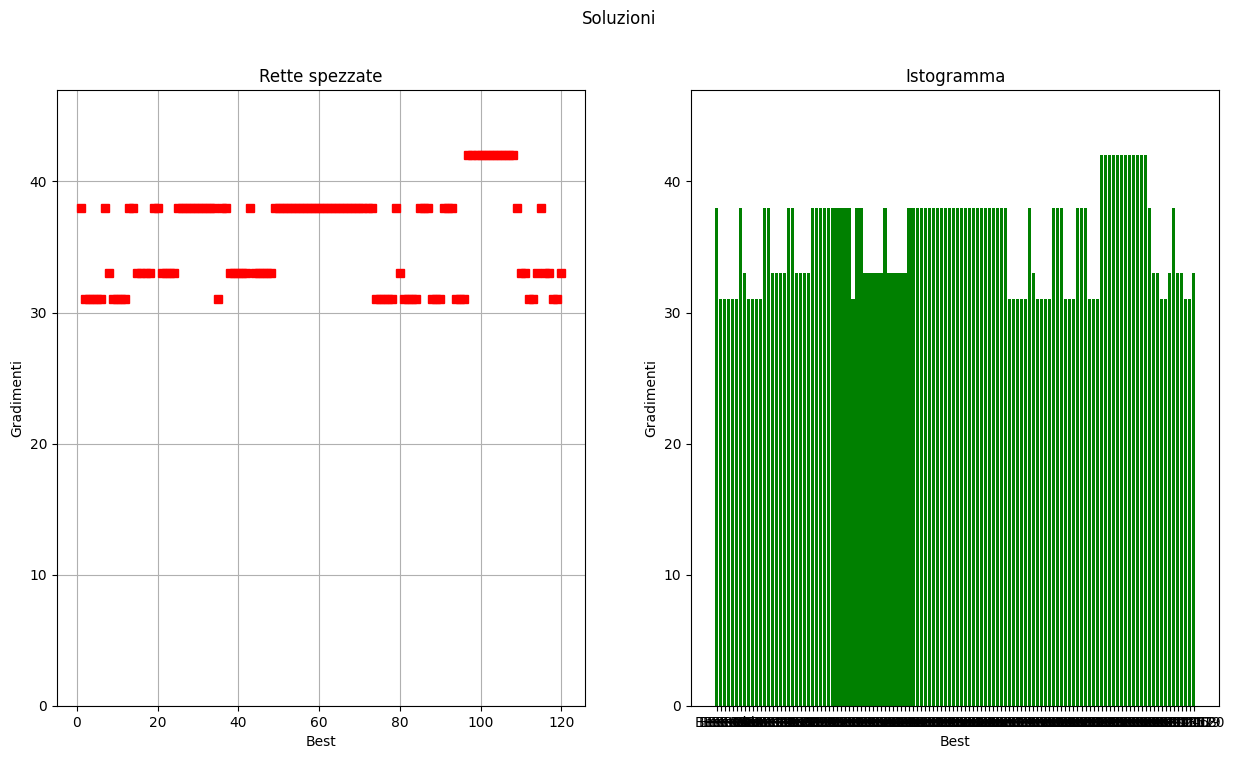

<Figure size 900x300 with 0 Axes>


SOLUZIONE MIGLIORE
[ Attr2 Attr7 Attr5 Attr10 Attr4 Attr6 Attr9 Attr1 Attr3 Attr8 ]


gradimento = 42

#######################################################################


 migliori_miglioramenti_DR_parametrica, gradimenti_migliori_miglioramenti_DR_parametrica
['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


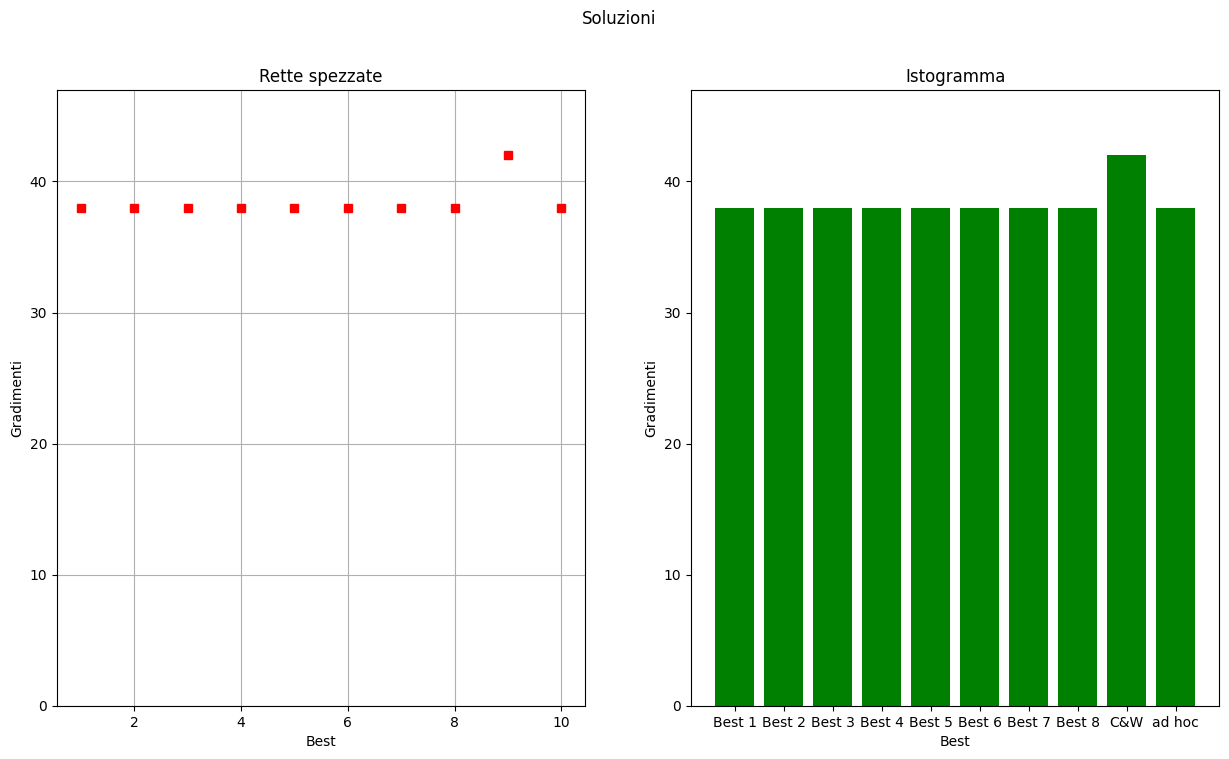

<Figure size 900x300 with 0 Axes>


SOLUZIONE MIGLIORE
[ Attr2 Attr7 Attr5 Attr10 Attr4 Attr6 Attr9 Attr1 Attr3 Attr8 ]


gradimento = 42

#######################################################################


 all_solutions_migliorate_DR_tabu, all_solutions_migliorate_gradimenti_tabu
['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


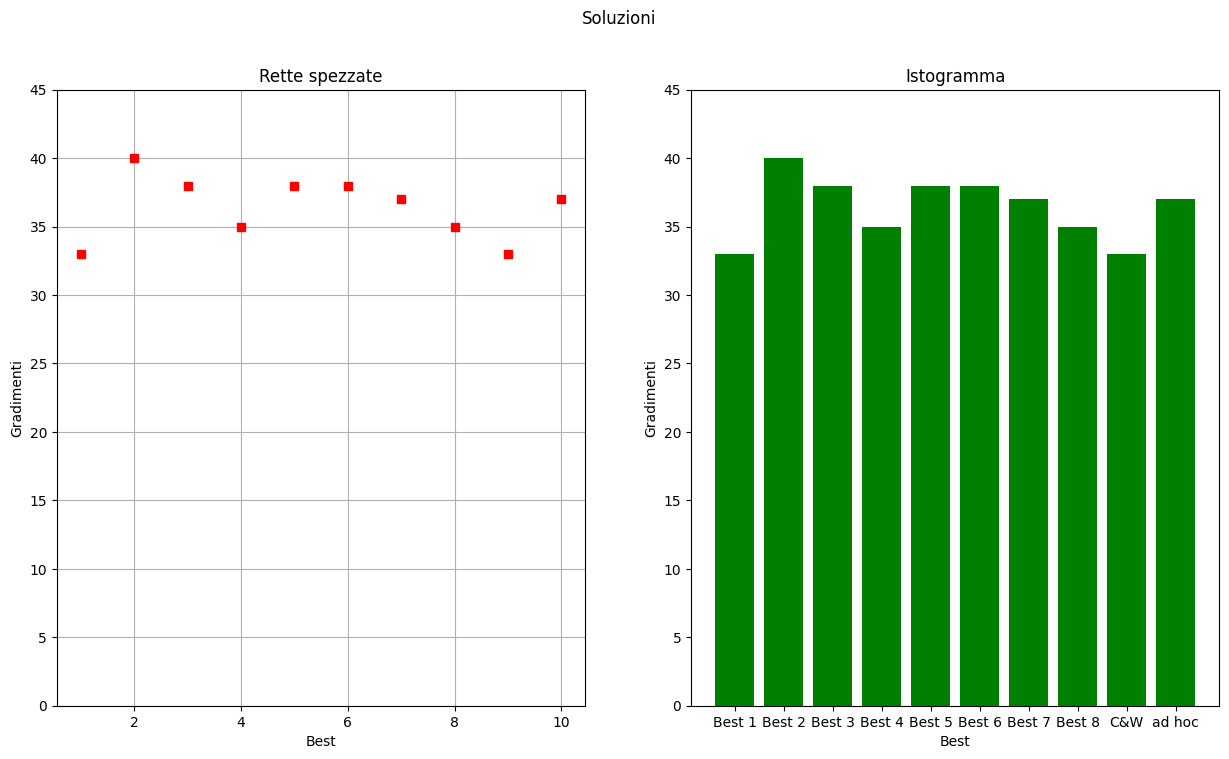

<Figure size 900x300 with 0 Axes>


SOLUZIONE MIGLIORE
[ Attr1 Attr3 Attr4 Attr5 Attr2 Attr10 Attr6 Attr9 Attr8 ]


gradimento = 40

#######################################################################


 DRI_in_DRP, gradimenti_DRI_in_DRP
['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc', 'Best 11', 'Best 12', 'Best 13', 'Best 14', 'Best 15', 'Best 16', 'Best 17', 'Best 18', 'Best 19', 'Best 20', 'Best 21', 'Best 22', 'Best 23', 'Best 24', 'Best 25', 'Best 26', 'Best 27', 'Best 28', 'Best 29', 'Best 30', 'Best 31', 'Best 32', 'Best 33', 'Best 34', 'Best 35', 'Best 36', 'Best 37', 'Best 38', 'Best 39', 'Best 40', 'Best 41', 'Best 42', 'Best 43', 'Best 44', 'Best 45', 'Best 46', 'Best 47', 'Best 48', 'Best 49', 'Best 50', 'Best 51', 'Best 52', 'Best 53', 'Best 54', 'Best 55', 'Best 56', 'Best 57', 'Best 58', 'Best 59', 'Best 60', 'Best 61', 'Best 62', 'Best 63', 'Best 64', 'Best 65', 'Best 66', 'Best 67', 'Best 68', 'Best 69', 'Best 70', 'Best 71', 'Best 72', 'Best 73', 'B

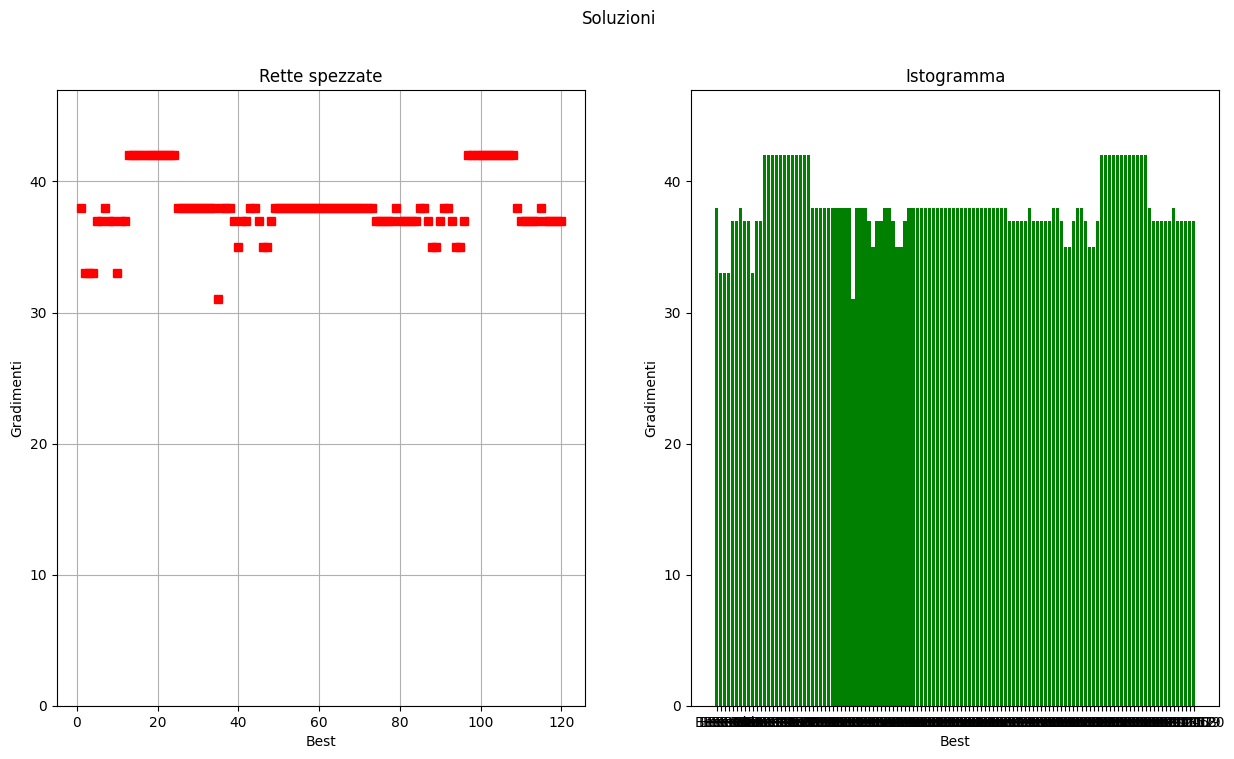

<Figure size 900x300 with 0 Axes>


 migliori_miglioramenti_DRI_in_DRP, gradimenti_migliori_miglioramenti_DRI_in_DRP
['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


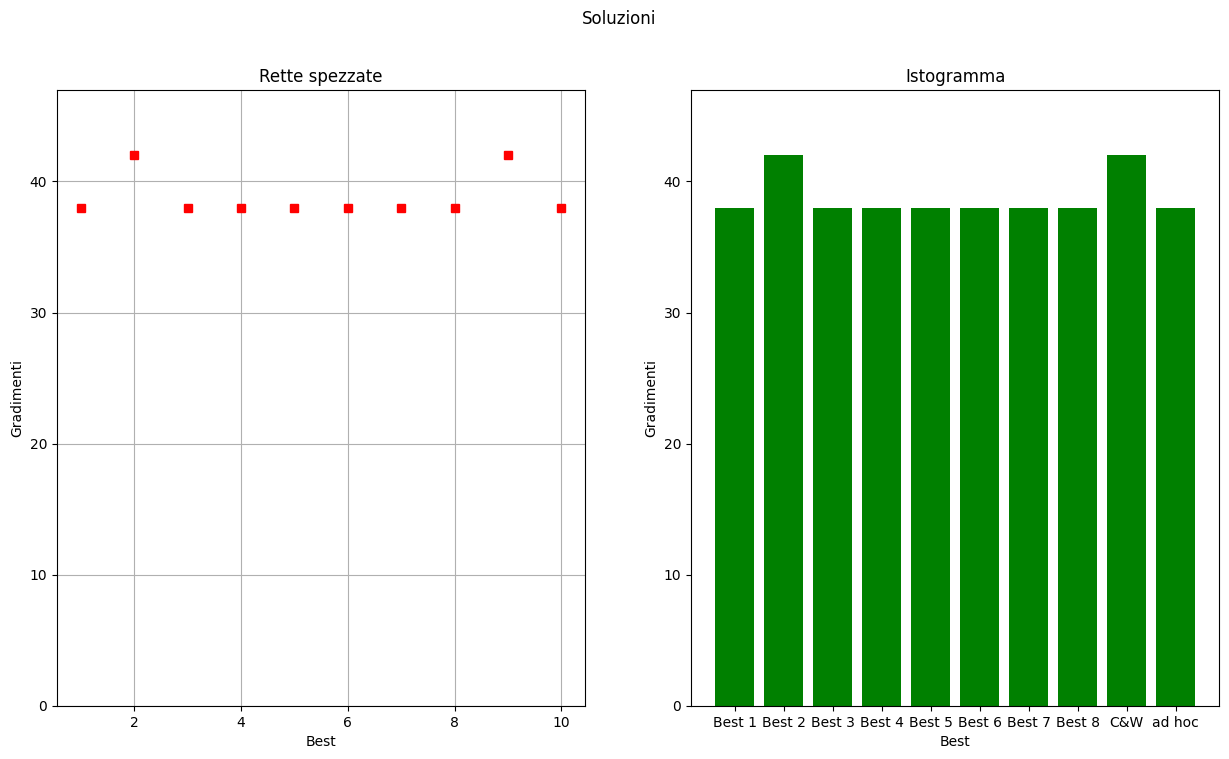

<Figure size 900x300 with 0 Axes>


SOLUZIONE MIGLIORE
[ Attr1 Attr3 Attr4 Attr5 Attr2 Attr9 Attr10 Attr8 Attr6 Attr7 ]


gradimento = 42

#######################################################################


 DRP_in_DRI,gradimenti_DRP_in_DRI
['Best 1', 'Best 2', 'Best 3', 'Best 4', 'Best 5', 'Best 6', 'Best 7', 'Best 8', 'C&W', 'ad hoc']


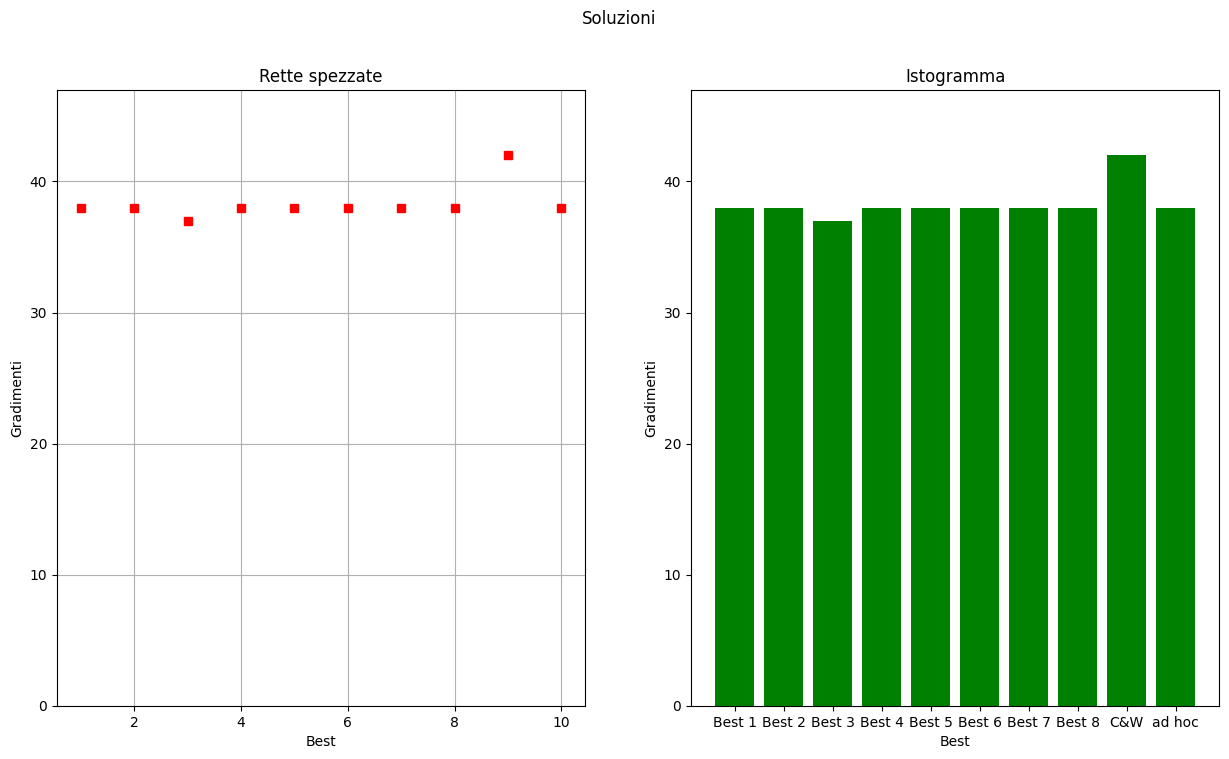

<Figure size 900x300 with 0 Axes>


SOLUZIONE MIGLIORE
[ Attr2 Attr7 Attr5 Attr10 Attr4 Attr6 Attr9 Attr1 Attr3 Attr8 ]


gradimento = 42

#######################################################################

Tempi esecuzione
Best 1 0.12731552124023438 ms
Best 2 0.11706352233886719 ms
Best 3 0.11134147644042969 ms
Best 4 0.11372566223144531 ms
Best 5 0.08916854858398438 ms
Best 6 0.22172927856445312 ms
Best 7 1.1911392211914062 ms
Best 8 0.21266937255859375 ms
Best 9 2.0477771759033203 ms
Best 10 5.739688873291016 ms
Best 11 61199.06663894653 ms
Best 12 489600.77953338623 ms
Best 13 461273.47135543823 ms
Best 14 50459.728479385376 ms


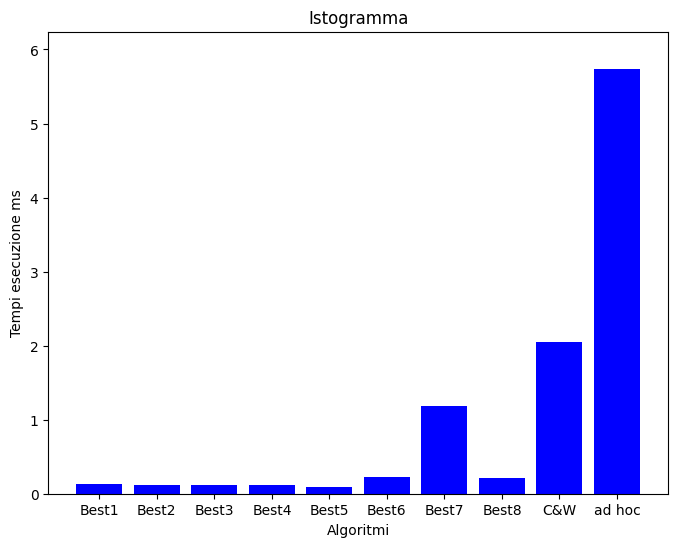

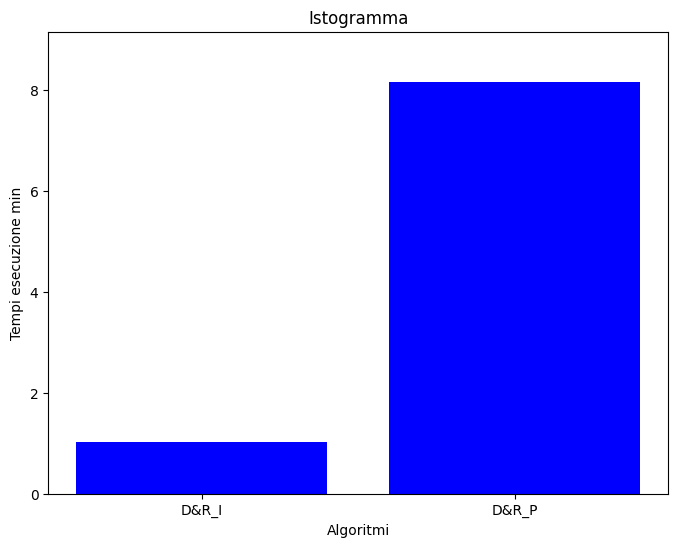

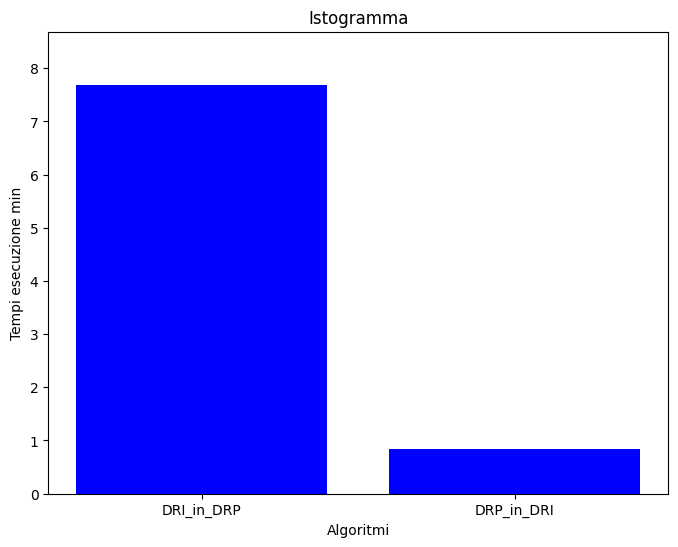

In [39]:
#plot e print riassuntive

print("seed =", SEED)
print("numero_di_attrazioni =", numero_di_attrazioni)
print("numero minimo di tw per ogni attrazione =", N_TW_MIN)
print("numero massimo di tw per ogni attrazione =", N_TW_MAX)
print("durata tour =", H)
print("range per le distanze casuali: D_MIN =",D_MIN, " D_MAX =",D_MAX)

L=[]
for key,value in attrazioni.items():
    L.append(Nodo(key,value,gradimenti[key],TW[key],START,0,START,None,None,D[0][key]))
max_gradimento_ottenibile = calcola_gradimento_soluzione(L)
print("somma dei gradimenti di tutte le attrazioni =", max_gradimento_ottenibile)



print("\n all_solutions,all_gradimenti")
plot_gradimenti_greedy(all_solutions,all_gradimenti)
tmp = []
tmp = migliori_migliorate(all_solutions)
gradimento_tmp = calcola_gradimento_soluzione(tmp)
print_soluzione(tmp)
print("gradimento =", gradimento_tmp)

print("\n#######################################################################\n")

print("\n all_solutions_migliorate_DR_parametrica, all_solutions_migliorate_gradimenti")
plot_gradimenti_greedy(all_solutions_migliorate_DR_parametrica,all_solutions_migliorate_gradimenti)
tmp = []
tmp = migliori_migliorate(all_solutions_migliorate_DR_parametrica)
gradimento_tmp = calcola_gradimento_soluzione(tmp)
print_soluzione(tmp)
print("gradimento =", gradimento_tmp)

print("\n#######################################################################\n")

print("\n migliori_miglioramenti_DR_parametrica, gradimenti_migliori_miglioramenti_DR_parametrica")
plot_gradimenti_greedy(migliori_miglioramenti_DR_parametrica,gradimenti_migliori_miglioramenti_DR_parametrica)
tmp = []
tmp = migliori_migliorate(migliori_miglioramenti_DR_parametrica)
gradimento_tmp = calcola_gradimento_soluzione(tmp)
print_soluzione(tmp)
print("gradimento =", gradimento_tmp)

print("\n#######################################################################\n")

print("\n all_solutions_migliorate_DR_tabu, all_solutions_migliorate_gradimenti_tabu")
plot_gradimenti_greedy(all_solutions_migliorate_DR_tabu,all_solutions_migliorate_gradimenti_tabu)
tmp = []
tmp = migliori_migliorate(all_solutions_migliorate_DR_tabu)
gradimento_tmp = calcola_gradimento_soluzione(tmp)
print_soluzione(tmp)
print("gradimento =", gradimento_tmp)

print("\n#######################################################################\n")

print("\n DRI_in_DRP, gradimenti_DRI_in_DRP")
plot_gradimenti_greedy(DRI_in_DRP, gradimenti_DRI_in_DRP)
print("\n migliori_miglioramenti_DRI_in_DRP, gradimenti_migliori_miglioramenti_DRI_in_DRP")
plot_gradimenti_greedy(migliori_miglioramenti_DRI_in_DRP,gradimenti_migliori_miglioramenti_DRI_in_DRP)
tmp = []
tmp = migliori_migliorate(migliori_miglioramenti_DRI_in_DRP)
gradimento_tmp = calcola_gradimento_soluzione(tmp)
print_soluzione(tmp)
print("gradimento =", gradimento_tmp)

print("\n#######################################################################\n")

print("\n DRP_in_DRI,gradimenti_DRP_in_DRI")
plot_gradimenti_greedy(DRP_in_DRI,gradimenti_DRP_in_DRI)
tmp = []
tmp = migliori_migliorate(DRP_in_DRI)
gradimento_tmp = calcola_gradimento_soluzione(tmp)
print_soluzione(tmp)
print("gradimento =", gradimento_tmp)

print("\n#######################################################################\n")


print('Tempi esecuzione')
for i in range(len(tempi_esecuzione)):
    print('Best '+ str(i+1)+ " "+str(tempi_esecuzione[i])+ " ms")

plot_tempi(tempi_esecuzione[:len(tempi_esecuzione)-4],["Best1","Best2","Best3","Best4","Best5","Best6","Best7","Best8","C&W","ad hoc"],max(tempi_esecuzione[:len(tempi_esecuzione)-4]),"ms",0.5)

print('\n')
tempi_ms=tempi_esecuzione[len(tempi_esecuzione)-4:len(tempi_esecuzione)-2]
tempi_minuti=list(map(lambda x: x/60000, tempi_ms))
plot_tempi(tempi_minuti,["D&R_I","D&R_P"],max(tempi_minuti),"min",1)


print('\n')
tempi_ms=tempi_esecuzione[len(tempi_esecuzione)-2:]
tempi_minuti=list(map(lambda x: x/60000, tempi_ms))
plot_tempi(tempi_minuti,["DRI_in_DRP","DRP_in_DRI"],max(tempi_minuti),"min",1)

